In [1]:
pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 torchtext==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 802.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
  Attemptin

In [2]:
# To install Falkon library
!pip install git+https://github.com/falkonml/falkon.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/falkonml/falkon.git to /tmp/pip-req-build-gt7kgu8x
  Running command git clone --filter=blob:none --quiet https://github.com/falkonml/falkon.git /tmp/pip-req-build-gt7kgu8x
  Resolved https://github.com/falkonml/falkon.git to commit e0f35851b00e181d6f2a5c52fc1aa160b1e7b0d6
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/getkeops/keops (to revision ad044a671fdc3c2790b0321f6b9f9b5aa3d220df) to /tmp/pip-install-h90z4c1i/keopscore_4ca702d453ea4d25bf8e18d123285afe
  Running command git clone --filter=blob:none --quiet https://github.com/getkeops/keops /tmp/pip-install-h90z4c1i/keopscore_4ca702d453ea4d25bf8e18d123285afe
  Running command git rev-parse -q --verify 'sha^ad044a671fdc3c2790b0321f6b9f9b5aa3d220df'
  Running command git fetch -q https://github.com/getkeops/keops ad044a671fdc3c2790b0321f6b9f9b5aa3d220df
  Running command git checkout 

In [3]:
import scipy
import torch
import falkon
import os, time
import itertools
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn import metrics
import matplotlib.pyplot as plt
from falkon import LogisticFalkon
from scipy.spatial.distance import pdist
from falkon.kernels import GaussianKernel
from falkon.options import FalkonOptions
from falkon.gsc_losses import WeightedCrossEntropyLoss
import matplotlib.font_manager as font_manager
from scipy.stats import norm, chi2, rv_continuous, kstest
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK
Mounted at /content/drive


In [4]:
def candidate_sigma(data, perc=90):
    # this function estimates the width of the gaussian kernel.
    # use on a (small) sample of reference data (standardize first if necessary)
    pairw = pdist(data)
    return round(np.percentile(pairw,perc),1)

'''
def NP2_gen(size, seed):
    # custom function to generate samples of non-resonant new physics events
    if size>10000:
        raise Warning('Sample size is grater than 1000: Generator will not approximate the tail well')
    sample = np.array([])
    #normalization factor                                                                                                                                    
    np.random.seed(seed)
    Norm = 256.*0.25*0.25*np.exp(-2)
    while(len(sample)<size):
        x = np.random.uniform(0,1) #assuming not to generate more than 10 000 events                                                                         
        p = np.random.uniform(0, Norm)
        if p<= 256.*x*x*np.exp(-8.*x):
            sample = np.append(sample, x)
    return sample
'''

class non_res(rv_continuous):

    def _pdf(self, x):

        return 256 * (x**2) * np.exp(- 8 * x)

def nonres_sig(N_S, seed):
    # this function can be used to generate non-resonant signal events.
    
    my_sig = non_res(momtype = 0, a=0, b=1, seed=seed)
    
    sig_sample = my_sig.rvs(size = N_S)
    
    return sig_sample


def get_logflk_config(M,flk_sigma,lam,weight,iter=[100],seed=None,cpu=False):
    # it returns logfalkon parameters
    return {
            'kernel' : GaussianKernel(sigma=flk_sigma),
            'M' : M, #number of Nystrom centers,
            'penalty_list' : lam, # list of regularization parameters,
            'iter_list' : iter, #list of number of CG iterations,
            'options' : FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=cpu, debug = False),
            'seed' : seed, # (int or None), the model seed (used for Nystrom center selection) is manually set,
            'loss' : WeightedCrossEntropyLoss(kernel=GaussianKernel(sigma=flk_sigma), neg_weight=weight),
            }


def compute_t(preds,Y,weight):
    # it returns extended log likelihood ratio from predictions
    diff = weight*np.sum(1 - np.exp(preds[Y==0]))
    return 2 * (diff + np.sum(preds[Y==1]))

def trainer(X,Y,flk_config):
    # trainer for logfalkon model
    Xtorch=torch.from_numpy(X)
    Ytorch=torch.from_numpy(Y)
    model = LogisticFalkon(**flk_config)
    model.fit(Xtorch, Ytorch)
    return model.predict(Xtorch).numpy()

def standardize(X):
    # standardize data as in HIGGS and SUSY
    for j in range(X.shape[1]):
        column = X[:, j]

        mean = np.mean(column)
        std = np.std(column)
    
        if np.min(column) < 0:
            column = (column-mean)*1./ std
        elif np.max(column) > 1.0:                                                                                                                                        
            column = column *1./ mean
    
        X[:, j] = column
    
    return X

def return_best_chi2dof(tobs):
    """
    Returns the most fitting value for dof assuming tobs follows a chi2_dof distribution,
    computed with a Kolmogorov-Smirnov test, removing NANs and negative values.
    Parameters
    ----------
    tobs : np.ndarray
        observations
    Returns
    -------
        best : tuple
            tuple with best dof and corresponding chi2 test result
    """
    
    
    dof_range = np.arange(np.nanmedian(tobs) - 10, np.nanmedian(tobs) + 10, 0.1)
    
    ks_tests = []
    
    for dof in dof_range:
        
        test = kstest(tobs, lambda x:chi2.cdf(x, df=dof))[0]
        
        ks_tests.append((dof, test))
        
    ks_tests = [test for test in ks_tests if test[1] != 'nan'] # remove nans
    
    ks_tests = [test for test in ks_tests if test[0] >= 0] # retain only positive dof
        
    best = min(ks_tests, key = lambda t: t[1]) # select best dof according to KS test result
        
    return best

In [5]:
def emp_zscore(t0,t1):
    if max(t0) <= t1:
        p_obs = 1 / len(t0)
        Z_obs = round(norm.ppf(1 - p_obs),2)
        return Z_obs
    else:
        p_obs = np.count_nonzero(t0 >= t1) / len(t0)
        Z_obs = round(norm.ppf(1 - p_obs),2)
        return Z_obs

def chi2_zscore(t1, dof):
    p = chi2.cdf(float('inf'),dof)-chi2.cdf(t1,dof)
    return norm.ppf(1 - p)

# Compatibility of t-dist with chi^2

In [ ]:
def err_bar(hist, n_samples):
    
    bins_counts = hist[0]
    bins_limits = hist[1]
    
    x   = 0.5*(bins_limits[1:] + bins_limits[:-1])
    
    bins_width = 0.5*(bins_limits[1:] - bins_limits[:-1])
    err = np.sqrt(np.array(bins_counts)/(n_samples*np.array(bins_width)))
    
    return x, err

In [ ]:
def plot_data(data, label, name=None, dof=None, out_path=None, title=None,
                 density=True, bins=10,
                 c='mediumseagreen', e='darkgreen'):
    """
    Plot reference vs new physics t distribution
    Parameters
    ----------
    data : np.ndarray or list
        (N_toy,) array of observed test statistics
    dof : int 
        degrees of freedom of the chi-squared distribution
    name : string
        filename for the saved figure
    out_path : string, optional
        output path where the figure will be saved. The default is ./fig.
    title : string
        title of the plot
    density : boolean
        True to normalize the histogram, false otherwise.
    bins : int or string, optional
        bins for the function plt.hist(). The default is 'fd'.
    Returns
    -------
    plot
    """
    
 
    plt.figure(figsize=(10,7))
    plt.style.use('classic')
    

    hist = plt.hist(data, bins = bins, color=c, edgecolor=e,
                        density=density, label = str(label))
    x_err, err = err_bar(hist, data.shape[0])
    plt.errorbar(x_err, hist[0], yerr = err, color=e, marker='o', ms=6, ls='', lw=1,
                 alpha=0.7)
    

    plt.ylim(bottom=0)
    
    # results data
    md_t = round(np.median(data), 2)
    if dof:
        z_chi2 = round(chi2_zscore(np.median(data),dof=dof),2)
    
    if dof:
        res = "md t = {} \nZ_chi2 = {}".format(md_t,z_chi2)
    else:
        res = "md t = {}".format(md_t)

    # plot chi2 and set xlim
    if dof:
        chi2_range = chi2.ppf(q=[0.00001,0.999], df=dof)
        x = np.arange(chi2_range[0], chi2_range[1], .05)
        chisq = chi2.pdf(x, df=dof)       
        plt.plot(x, chisq, color='#d7191c', lw=2, label='$\chi^2(${}$)$'.format(dof))
        xlim = (min(chi2_range[0], min(data)-5), max(chi2_range[1], max(data)+5))
        plt.xlim(chi2_range)
    else:
        xlim = (min(data)-5, max(data)+5)
        plt.xlim(xlim)


    if title:
        plt.title(title, fontsize=20)
    
    plt.ylabel('P(t)', fontsize=20)
    plt.xlabel('t', fontsize=20)
    
    # Axes ticks
    ax = plt.gca()
    
    plt.legend(loc ="upper right", frameon=True, fontsize=18)
    
    ax.text(0.75, 0.65, res, color='black', fontsize=12,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.5'),transform = ax.transAxes)
    
    plt.tight_layout()
    
    if out_path:
        plt.savefig(out_path+"/data_{}.pdf".format(name), bbox_inches='tight')
    
    plt.show()
        
    plt.close()

In [ ]:
def plot_ref_data(ref, data, name=None, dof=None, out_path=None, title=None,
                 density=True, bins=10,
                 c_ref='#abd9e9', e_ref='#2c7bb6', c_sig='#fdae61', e_sig='#d7191c'):
    """
    Plot reference vs new physics t distribution
    Parameters
    ----------
    T_ref : np.ndarray or list
        (N_toy,) array of observed test statistics in the reference hypothesis
    T_sig : np.ndarray or list
        (N_toy,) array of observed test statistics in the New Physics hypothesis
    dof : int 
        degrees of freedom of the chi-squared distribution
    name : string
        filename for the saved figure
    out_path : string, optional
        output path where the figure will be saved. The default is ./fig.
    title : string
        title of the plot
    density : boolean
        True to normalize the histogram, false otherwise.
    bins : int or string, optional
        bins for the function plt.hist(). The default is 'fd'.
    Returns
    -------
    plot
    """
    
 
    plt.figure(figsize=(10,7))
    plt.style.use('classic')
    #set uniform bins across all data points
    bins = np.histogram(np.hstack((ref,data)), bins = bins)[1]
    
    # reference
    hist_ref = plt.hist(ref, bins = bins, color=c_ref, edgecolor=e_ref,
                        density=density, label = 'Reference')
    x_err, err = err_bar(hist_ref, ref.shape[0])
    plt.errorbar(x_err, hist_ref[0], yerr = err, color=e_ref, marker='o', ms=6, ls='', lw=1,
                 alpha=0.7)
    # data
    hist_sig = plt.hist(data, bins = bins, color=c_sig, edgecolor=e_sig,
                        alpha=0.7, density=density, label='Data')
    x_err, err = err_bar(hist_sig, data.shape[0])
    plt.errorbar(x_err, hist_sig[0], yerr = err, color=e_sig, marker='o', ms=6, ls='', lw=1,
                 alpha=0.7)
    

    plt.ylim(bottom=0)
    
    # results data
    md_tref = round(np.median(ref), 2)
    md_tdata = round(np.median(data), 2)
    max_zemp = emp_zscore(ref,np.max(ref))
    zemp = emp_zscore(ref,np.median(data))
    if dof:
        z_chi2 = round(chi2_zscore(np.median(data),dof=dof),2)
    
    if dof:
        res = "md t_ref = {} \nmd t_data = {} \nmax Z_emp = {}  \nZ_emp = {} \nZ_chi2 = {}".format(
            md_tref,
            md_tdata,
            max_zemp,
            zemp,
            z_chi2
        )
    else:
        res = "md tref = {} \nmd tdata = {} \nmax Zemp = {} \nZemp = {}".format(
            md_tref,
            md_tdata,
            max_zemp,
            zemp
        )

    # plot chi2 and set xlim
    if dof:
        chi2_range = chi2.ppf(q=[0.00001,0.999], df=dof)
        #r_len = chi2_range[1] - chi2_range[0]
        x = np.arange(chi2_range[0], chi2_range[1], .05)
        chisq = chi2.pdf(x, df=dof)       
        plt.plot(x, chisq, color='#d7191c', lw=2, label='$\chi^2(${}$)$'.format(dof))
        xlim = (min(chi2_range[0], min(ref)-1), max(chi2_range[1], max(data)+1))
        plt.xlim(xlim)
    else:
        xlim = (min(ref)-1, max(data)+1)
        plt.xlim(xlim)


    if title:
        plt.title(title, fontsize=20)
    
    plt.ylabel('P(t)', fontsize=20)
    plt.xlabel('t', fontsize=20)
    
    # Axes ticks
    ax = plt.gca()
    
    plt.legend(loc ="upper right", frameon=True, fontsize=18)
    
    ax.text(0.75, 0.55, res, color='black', fontsize=12,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.5'),transform = ax.transAxes)
    
    plt.tight_layout()
    
    if out_path:
        plt.savefig(out_path+"/refdata_{}.pdf".format(name), bbox_inches='tight')
        
    plt.close()

In [ ]:
def metrics_plots(data_path, output_path, N_0, N0, NS, flk_config, df=10, savefig=True):
  '''
  plotting the AUC ROC, and PR curves
  '''

  weight = N0/N_0
  # loading data
  df = pd.read_csv(data_path)

    
  # dividing the dataset
  fraud_df = df.loc[df['Class'] == 1]
  non_fraud_df = df.loc[df['Class'] == 0]

  dim = 2
  rng = np.random.default_rng(123)

  # Shuffling the data
  df = df.sample(frac=1, random_state=123)
  fraud_df = fraud_df.sample(frac=1,random_state=123)
  non_fraud_df = non_fraud_df.sample(frac=1,random_state=123)

  N0p = rng.poisson(lam=N0)
  NSp = rng.poisson(lam=NS) # if data contains anomalies
  N = N_0 + N0p + NSp

  X = np.zeros(shape=(N,dim))
  X[:N_0+N0p,:] = non_fraud_df[['V11','V14']].sample(n= N_0+N0p, replace=False, random_state=123) # ref and bkg
  X[N_0+N0p:,:] = fraud_df[['V11','V14']].sample(n= NSp, replace=False, random_state=123) # signal
  # initialize labes
  Y = np.zeros(shape=(N,1))
  Y[N_0:,:] = np.ones((N0p+NSp,1)) # flip data labels to one
  X = np.array(X)

  preds = trainer(X,Y,flk_config)

  curve, ax = plt.subplots(2, 1, figsize=(15,10))

  # AUC ROC curve

  FPR_list, TPR_list, threshold = metrics.roc_curve(Y, preds)
  ROC_AUC = metrics.auc(FPR_list, TPR_list)
    
  get_template_roc_curve(ax[0],title='Receiver Operating Characteristic Curve',fs=15)

  ax[0].plot(FPR_list, TPR_list, 'b', label = 'AUC ROC = {0:0.3f}'.format(ROC_AUC))
  ax[0].legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))



  # PR (Precision Recall) curve

  get_template_pr_curve(ax[1], "Precision Recall (PR) Curve", fs=15, baseline = sum(np.array(Y))/len(np.array(Y)))

  precision, recall, threshold = metrics.precision_recall_curve(Y, preds)
  precision=precision[::-1]
  recall=recall[::-1]

  AP = metrics.average_precision_score(Y, preds)

  ax[1].step(recall, precision, 'b', label = 'AP = {0:0.3f}'.format(AP))
  ax[1].legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.8)

  if output_path:
      plt.savefig(output_path+"/metric_plots.pdf", bbox_inches='tight')
    
  plt.close()

In [ ]:
def plot_reconstruction(df, data, weight_data, ref, weight_ref, t_obs, ref_preds,
                        save=False, save_path='', file_name=''):
    '''
    Reconstruction of the data distribution learnt by the model.
    
    df:              (int) chi2 degrees of freedom
    data:            (numpy array, shape (None, n_dimensions)) data training sample (label=1)
    weight_data:     (numpy array, shape (None,)) weights of the data sample (default ones)
    ref:             (numpy array, shape (None, n_dimensions)) reference training sample (label=0)
    weight_ref:      (numpy array, shape (None,)) weights of the reference sample
    tau_OBS:         (float) value of the tau term after training
    output_tau_ref:  (numpy array, shape (None, 1)) tau prediction of the reference training sample after training
    feature_labels:  (list of string) list of names of the training variables
    bins_code:       (dict) dictionary of bins edge for each training variable (bins_code.keys()=feature_labels)
    xlabel_code:     (dict) dictionary of xlabel for each training variable (xlabel.keys()=feature_labels)
    ymax_code:       (dict) dictionary of maximum value for the y axis in the ratio panel for each training variable (ymax_code.keys()=feature_labels)
    delta_OBS:       (float) value of the delta term after training (if not given, only tau reconstruction is plotted)
    output_delta_ref:(numpy array, shape (None, 1)) delta prediction of the reference training sample after training (if not given, only tau reconstruction is plotted)
    '''
    # used to regularize empty reference bins
    eps = 1e-10 

    weight_ref = np.ones(len(ref))*weight_ref
    weight_data = np.ones(len(data))*weight_data

    # Dimention
    dim = data.shape[-1]
    
    Zscore=norm.ppf(chi2.cdf(t_obs, df))

    for i in range(dim):

      bins = np.linspace(0,1.5,24)
      plt.rcParams["font.family"] = "serif"
      plt.style.use('classic')
      fig = plt.figure(figsize=(8, 8)) 
      fig.patch.set_facecolor('white')
      fig.suptitle(f"dim_{i+1}", fontsize="x-large")
      ax1= fig.add_axes([0.1, 0.43, 0.8, 0.5])        
      hD = plt.hist(data[:, i],weights=weight_data, bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=2)
      hR = plt.hist(ref[:, i], weights=weight_ref, color='#a6cee3', ec='#1f78b4', bins=bins, lw=1, label='REFERENCE', zorder=1)
      hN = plt.hist(ref[:, i], weights=np.exp(ref_preds[:, 0])*weight_ref, histtype='step', bins=bins, lw=0)
    
      plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0], yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
      plt.scatter(0.5*(bins[1:]+bins[:-1]),  hN[0], edgecolor='black', label='RECO', color='#b2df8a', lw=1, s=30, zorder=4)

      font = font_manager.FontProperties(family='serif', size=16)
      l    = plt.legend(fontsize=18, prop=font, ncol=2)
      font = font_manager.FontProperties(family='serif', size=18) 
      title  = 't='+str(np.around(t_obs, 2))
      
      title += ', Z-score='+str(np.around(Zscore, 2))
      l.set_title(title=title, prop=font)
      plt.tick_params(axis='x', which='both',    labelbottom=False)
      plt.yticks(fontsize=16, fontname='serif')
      plt.xlim(0, 1.5)
      plt.ylabel("events", fontsize=22, fontname='serif')
      plt.yscale('log')
      ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.3]) 
      x   = 0.5*(bins[1:]+bins[:-1])
      plt.errorbar(x, hD[0]/(hR[0]+eps), yerr=np.sqrt(hD[0])/(hR[0]+eps), ls='', marker='o', label ='DATA/REF', color='black')
      plt.plot(x, hN[0]/(hR[0]+eps), label ='RECO', color='#b2df8a', lw=3)

      font = font_manager.FontProperties(family='serif', size=16)
      plt.legend(fontsize=18, prop=font)
      plt.xlabel('x', fontsize=22, fontname='serif')
      plt.ylabel("ratio", fontsize=22, fontname='serif')

      plt.yticks(fontsize=16, fontname='serif')
      plt.xticks(fontsize=16, fontname='serif')
      plt.xlim(bins[0], bins[-1])
      plt.ylim(0,10)
      plt.grid()
      if save:
          os.makedirs(save_path, exist_ok=True)
          fig.savefig(save_path + 'dim'+ '-'+ '{}'.format(i+1)+ file_name)
      plt.show()
      plt.close()

    return

In [ ]:
# for 2-D with plot-reconstruction (with passing data)

def run_toys(sig, data, fraud, genuine, output_path, N_0, N0, NS, flk_config, toys=np.arange(100), plots_freq=0, df=10, savefig=True):

    '''
    type of signal: "NP0", "NP1", "NP2", "NP3"
    output_path: directory (inside ./runs/) where to save results
    N_0: size of ref sample
    N0: expected num of bkg events
    NS: expected num of signal events
    flk_config: dictionary of logfalkon parameters
    toys: numpy array with seeds for toy generation
    plots_freq: how often to plot inputs with learned reconstructions
    df: degree of freedom of chi^2 for plots
    '''

    output_path = "./runs/" + output_path
    os.makedirs(output_path, exist_ok=True)

    #save config file (temporary solution)
    with open(output_path+"/flk_config.txt","w") as f:
        f.write( str(flk_config) )

    weight = N0/N_0
    # passing data
    samples = data

    
    # dividing the dataset
    fraud_df = fraud
    non_fraud_df = genuine

    dim = 2

    for i in toys:

        st_time = time.time()

        rng = np.random.default_rng(i)

        # Shuffling the data
        samples = samples.sample(frac=1, random_state=i)
        fraud_df = fraud_df.sample(frac=1,random_state=i)
        non_fraud_df = non_fraud_df.sample(frac=1,random_state=i)

        N0p = rng.poisson(lam=N0)
        if sig!="NP0": NSp = rng.poisson(lam=NS) # if data contains anomalies
        else: NSp = 0

        N = N_0 + N0p + NSp

        print("[--] Toy {}: ".format(i))
        # build training set
        # initialize dataset
        # fill with ref, bkg and data
        if sig=="NP0":
            X = non_fraud_df[['V11','V14']].sample(n= N, replace=False, random_state=i) # both reference and data contain only bkg events (no NP component)
        else:
            X = np.zeros(shape=(N,dim))
            X[:N_0+N0p,:] = non_fraud_df[['V11','V14']].sample(n= N_0+N0p, replace=False, random_state=i) # ref and bkg
            X[N_0+N0p:,:] = fraud_df[['V11','V14']].sample(n= NSp, replace=False, random_state=i) # signal
        # initialize labes
        Y = np.zeros(shape=(N,1))
        Y[N_0:,:] = np.ones((N0p+NSp,1)) # flip data labels to one
        X = np.array(X)
        
        print("[--] Reference shape:{}".format(X[Y.flatten()==0].shape))
        print("[--] Data shape:{}".format(X[Y.flatten()==1].shape))

        # in this 1D case, there is no need to standardize
        #Xoriginal = X.copy()
        #X = standardize(X)

        # learn_t
        flk_config['seed']=i # select different centers for different toys

        preds = trainer(X,Y,flk_config)

        t = compute_t(preds,Y,weight)

        dt = round(time.time()-st_time,2)

        print("t = {}\nTime = {} sec\n\t".format(t,dt))

        with open(output_path+"t.txt", 'a') as f:
            f.write('{},{}\n'.format(i,t))
        
        if plots_freq!=0 and t>0 and i in toys[::plots_freq]:
            plot_reconstruction(data=X[Y.flatten()==1], weight_data=1, ref=X[Y.flatten()==0], weight_ref=weight, df=df, t_obs=t, ref_preds=preds[Y.flatten()==0],
                        save=savefig, save_path=output_path+'/plots/', file_name='sig_'+sig+'_NS{}_seed{}.pdf'.format(NS,i)
                    )

In [ ]:
!rm /content/runs/reference/t.txt
!rm /content/runs/NP1/t.txt

rm: cannot remove '/content/runs/reference/t.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/t.txt': No such file or directory


[--] Toy 0: 
[--] Reference shape:(1000, 2)
[--] Data shape:(610, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 115.90010483711153
Time = 12.13 sec
	


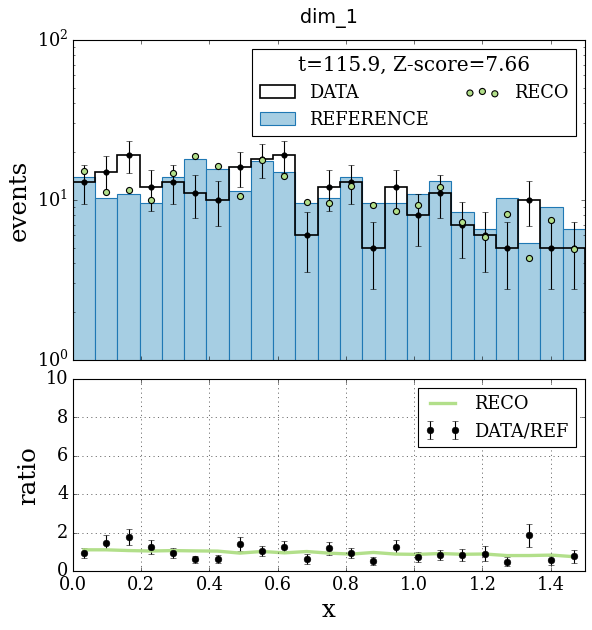

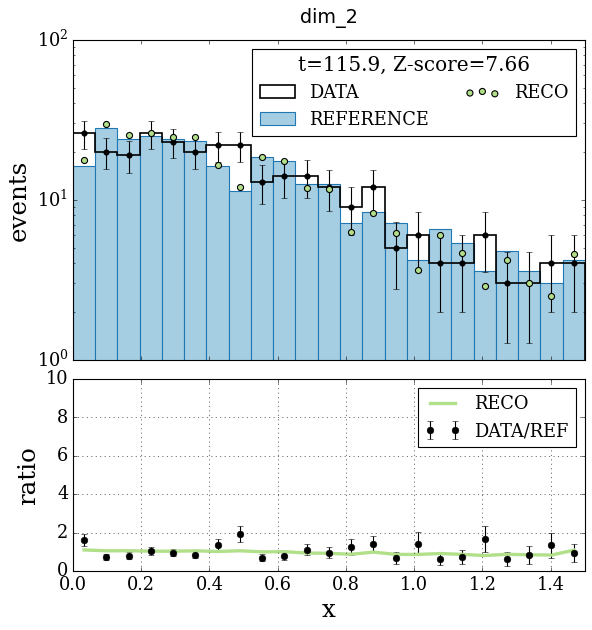

[--] Toy 1: 
[--] Reference shape:(1000, 2)
[--] Data shape:(601, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 69.79477141407693
Time = 1.48 sec
	
[--] Toy 2: 
[--] Reference shape:(1000, 2)
[--] Data shape:(582, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 71.12921770578424
Time = 1.98 sec
	
[--] Toy 3: 
[--] Reference shape:(1000, 2)
[--] Data shape:(559, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 89.1341781902416
Time = 3.22 sec
	
[--] Toy 4: 
[--] Reference shape:(1000, 2)
[--] Data shape:(651, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 65.20389464954387
Time = 2.4 sec
	
[--] Toy 5: 
[--] Reference shape:(1000, 2)
[--] Data shape:(624, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 69.6521064907306
Time = 1.56 sec
	
[--] Toy 6: 
[--] Reference shape:(1000, 2)
[--] Data shape:(603, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 50.61012562918875
Time = 1.16 sec
	
[--] Toy 7: 


In [ ]:
N_0 = 1000 # size of reference sample
N0 = 600 # expected background
weight = N0/N_0

M = 150
lam = 1e-10
flk_sigma = 3
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function

# null hypothesis
NS = 0 # expected NP component
run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS, flk_config, toys=np.arange(300), plots_freq= 500, df= 22)

In [ ]:
best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])
best

(74.6757010740063, 0.05481792803712928)

[--] Toy 0: 
[--] Reference shape:(1000, 2)
[--] Data shape:(619, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 131.79339320052452
Time = 0.79 sec
	


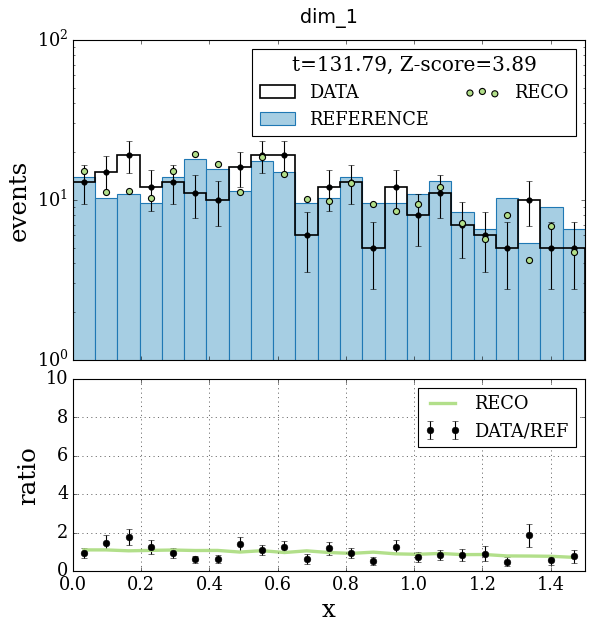

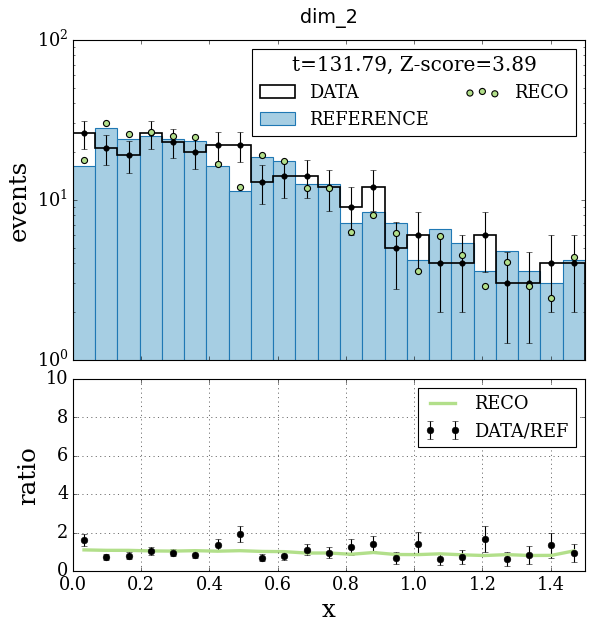

[--] Toy 1: 
[--] Reference shape:(1000, 2)
[--] Data shape:(618, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 97.80514495990235
Time = 0.71 sec
	
[--] Toy 2: 
[--] Reference shape:(1000, 2)
[--] Data shape:(607, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 123.9116058288921
Time = 0.72 sec
	
[--] Toy 3: 
[--] Reference shape:(1000, 2)
[--] Data shape:(583, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 135.1150062872971
Time = 0.72 sec
	
[--] Toy 4: 
[--] Reference shape:(1000, 2)
[--] Data shape:(687, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 149.62655510054785
Time = 0.71 sec
	
[--] Toy 5: 
[--] Reference shape:(1000, 2)
[--] Data shape:(644, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 121.96175856827983
Time = 0.9 sec
	
[--] Toy 6: 
[--] Reference shape:(1000, 2)
[--] Data shape:(621, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 85.53019268997107
Time = 0.95 sec
	
[--] Toy 

In [ ]:
N_0 = 1000 # size of reference sample
N0 = 600 # expected background
weight = N0/N_0

M = 150
lam = 1e-10
flk_sigma = 3
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function

# null hypothesis
NS = 20 # expected NP component
run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), plots_freq= 200, df= best[0])

FileNotFoundError: ignored

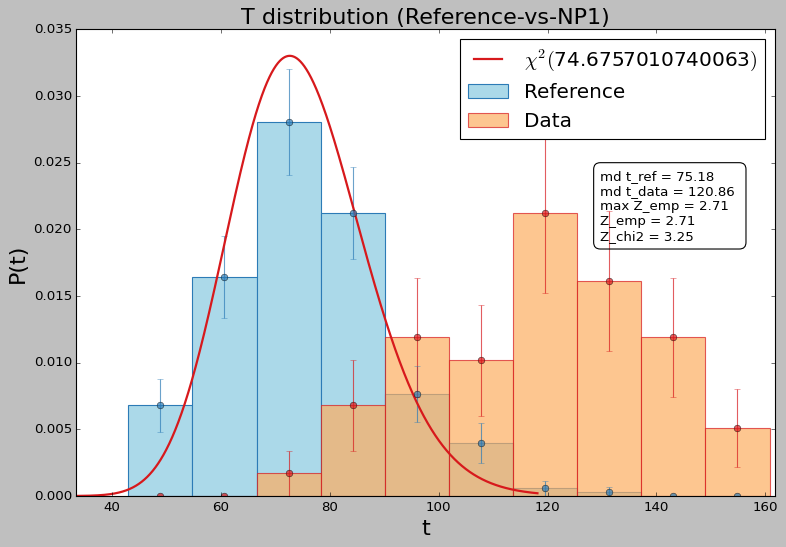

In [ ]:
# in utils.py you additional functions can be found to plot the test statistics
tobs = np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1]
tobs = [t for t in tobs if t >= 0]  # remove the negative element

plot_ref_data(ref=np.array(tobs), data=np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1], dof=best[0],
              name='NP1', out_path='./fig', title='T distribution (Reference-vs-NP1)', density=True, bins=10,
              c_ref='#abd9e9', e_ref='#2c7bb6', c_sig='#fdae61', e_sig='#d7191c')

In [ ]:
files.download("/content/fig/refdata_NP1.pdf")

Based on different combination of N_0 and N0, the best one fits the chi-2 is : N_0= 1000, and N0= 600

# Parameters of the Model (Lambda and M)

In [ ]:
# for 2-D without plot-reconstruction (with passing data)

def run_toys(sig, data, fraud, genuine, output_path, N_0, N0, NS, flk_config, toys=np.arange(100), plots_freq=0, df=10, savefig=True):

    '''
    type of signal: "NP0", "NP1", "NP2", "NP3"
    output_path: directory (inside ./runs/) where to save results
    N_0: size of ref sample
    N0: expected num of bkg events
    NS: expected num of signal events
    flk_config: dictionary of logfalkon parameters
    toys: numpy array with seeds for toy generation
    plots_freq: how often to plot inputs with learned reconstructions
    df: degree of freedom of chi^2 for plots
    '''

    output_path = "./runs/" + output_path
    os.makedirs(output_path, exist_ok=True)

    #save config file (temporary solution)
    with open(output_path+"/flk_config.txt","w") as f:
        f.write( str(flk_config) )

    weight = N0/N_0
    # passing data
    samples = data

    
    # dividing the dataset
    fraud_df = fraud
    non_fraud_df = genuine

    dim = 2

    for i in toys:

        st_time = time.time()

        rng = np.random.default_rng(i)

        # Shuffling the data
        samples = samples.sample(frac=1, random_state=i)
        fraud_df = fraud_df.sample(frac=1,random_state=i)
        non_fraud_df = non_fraud_df.sample(frac=1,random_state=i)

        N0p = rng.poisson(lam=N0)
        if sig!="NP0": NSp = rng.poisson(lam=NS) # if data contains anomalies
        else: NSp = 0

        N = N_0 + N0p + NSp

        if sig=="NP0":
            X = non_fraud_df[['V11','V14']].sample(n= N, replace=False, random_state=i) # both reference and data contain only bkg events (no NP component)
        else:
            X = np.zeros(shape=(N,dim))
            X[:N_0+N0p,:] = non_fraud_df[['V11','V14']].sample(n= N_0+N0p, replace=False, random_state=i) # ref and bkg
            X[N_0+N0p:,:] = fraud_df[['V11','V14']].sample(n= NSp, replace=False, random_state=i) # signal
        # initialize labes
        Y = np.zeros(shape=(N,1))
        Y[N_0:,:] = np.ones((N0p+NSp,1)) # flip data labels to one
        X = np.array(X)
        
        # learn_t
        flk_config['seed']=i # select different centers for different toys

        preds = trainer(X,Y,flk_config)

        t = compute_t(preds,Y,weight)

        dt = round(time.time()-st_time,2)

        
        with open(output_path+"t.txt", 'a') as f:
            f.write('{},{}\n'.format(i,t))
        with open(output_path+"time.txt",'a') as f:
            f.write('{},{}\n'.format(i,dt))

In [ ]:
def get_results(ref, r_time,dof=None):
  
  avr_tref = round(np.mean(ref),2)
  avr_ref_time = round(np.mean(r_time),2)
  
  if dof:
      DoF = dof[0]
      ktest = dof[1]

  return {"avr_ref_time":avr_ref_time,
          "avr_tref":avr_tref,
          "dof":DoF,
          "Ktest":ktest}

In [ ]:
def GridSearch(parms):

  res = []

  # Loading the dataset
  creds = pd.read_csv("/content/drive/MyDrive/CreditCards/creditcard.csv")
  fraud_samples = creds.loc[creds['Class'] == 1]
  genuine_samples = creds.loc[creds['Class'] == 0]

  combinations = itertools.product(*(parms[Name] for Name in parms.keys()))
  for row in list(combinations):

    # M should be less than N_0 and N0
    if row[2]<row[0] and row[2]<row[1]:
      if row[0]>row[1]:
        # parameters
        flk_sigma = 3
        N_0, N0, M, lam = row[0], row[1], row[2], row[3]
        weight = N0/N_0

        flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False)

        #clearing previous results
        !rm /content/runs/reference/t.txt
        !rm /content/runs/reference/time.txt

        # Running the codes on reference dataset 
        NS_temp = 0
        run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS_temp, flk_config, toys=np.arange(300), df= 22)

        # Best DoF
        best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])

        # Collecting the important results for comparison
        results = get_results(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1],
                              np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1],
                              dof=best)

        # adding the parameters info to the collected data for comparison
        results.update({"N_0": N_0, "N0": N0, "M": M, "lam": lam})
        # Updating the whole Results
        res.append(results)


  return res

In [ ]:
parameters = {"N_0":[1500],"N0":[800],"M":[20,50,100,300,600],"lam":[1e-4,1e-6,1e-8,1e-9,1e-10]}
my_dict = GridSearch(parameters)
res_df = pd.DataFrame(my_dict)

Streaming output truncated to the last 5000 lines.
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 100
Iteration 0 - penalty 1.000000e-09 - sub-iterations 1

In [ ]:
res_df.to_csv("GridSearch_Results(Model-param).csv",index=False)
res_df

,avr_ref_time,avr_tref,dof,Ktest,N_0,N0,M,lam
0,0.29,14.99,14.831505,0.026941,1500,800,20,1.000000e-04
1,0.34,28.41,28.041362,0.058353,1500,800,20,1.000000e-06
2,0.39,32.71,32.269334,0.067651,1500,800,20,1.000000e-08
3,0.45,32.78,32.439699,0.064626,1500,800,20,1.000000e-09
4,0.55,32.79,32.536733,0.064194,1500,800,20,1.000000e-10
5,0.23,15.71,15.508995,0.022504,1500,800,50,1.000000e-04
6,0.29,33.53,33.139914,0.043545,1500,800,50,1.000000e-06
7,0.56,50.88,50.624045,0.049273,1500,800,50,1.000000e-08
8,0.76,57.57,56.968809,0.060891,1500,800,50,1.000000e-09
9,0.77,62.04,61.545436,0.056377,1500,800,50,1.000000e-10


In [ ]:
fig = px.line(res_df, x='M', y='avr_tref', color = 'lam', text='avr_tref')
fig.update_layout(title = { 'text' : "Avr_tref--vs--M\n (N_0= 1500, N0= 800)", 'x' : 0.5 })
fig.update_traces(textposition="middle center")
fig.show()

According to the previous plot, we can see that the average of t-distribution will increase by reducing the lambda.
Now we have to check the average time for each of them to decide which one/ones could be the best option(s).

In [ ]:
fig = px.line(res_df, x='M', y='avr_ref_time', color = 'lam', text='avr_ref_time')
fig.update_layout(title = { 'text' : "Average reference time --vs --M\n (N_0= 1500, N0= 800)", 'x' : 0.5 })
fig.update_traces(textposition="middle center")
fig.show()

According to this plot, by reducing the lambda, the average time will increase (which is expected since we are increasing the complexity of the model). However, there is a trend in this plot that by increasing the M, the average time will decrease (exept for lambda= 1e-10).
Now we have to choose which point(s) are optimum. But we need to choose them according to a scale:
If our scale is complexity of the model (the more, the better): we have to choose: lambda= 1e-10 and M >= 150
If our scale is the average time and the complexity, then our choice would be: lambda = 1e-8 and M >= 150.
For the rest of my experiment, I will choose the  secend option because the time is importent for me.

In [ ]:
files.download("GridSearch_Results(Model-param).csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Parameters of the dataset (NS)

In [ ]:
# for 2-D without plot-reconstruction (with passing data)

def run_toys(sig, data, fraud, genuine, output_path, N_0, N0, NS, flk_config, toys=np.arange(100), plots_freq=0, df=10, savefig=True):

    '''
    type of signal: "NP0", "NP1", "NP2", "NP3"
    output_path: directory (inside ./runs/) where to save results
    N_0: size of ref sample
    N0: expected num of bkg events
    NS: expected num of signal events
    flk_config: dictionary of logfalkon parameters
    toys: numpy array with seeds for toy generation
    plots_freq: how often to plot inputs with learned reconstructions
    df: degree of freedom of chi^2 for plots
    '''

    output_path = "./runs/" + output_path
    os.makedirs(output_path, exist_ok=True)

    #save config file (temporary solution)
    with open(output_path+"/flk_config.txt","w") as f:
        f.write( str(flk_config) )

    weight = N0/N_0
    # passing data
    samples = data

    
    # dividing the dataset
    fraud_df = fraud
    non_fraud_df = genuine

    dim = 2

    for i in toys:

        st_time = time.time()

        rng = np.random.default_rng(i)

        # Shuffling the data
        samples = samples.sample(frac=1, random_state=i)
        fraud_df = fraud_df.sample(frac=1,random_state=i)
        non_fraud_df = non_fraud_df.sample(frac=1,random_state=i)

        N0p = rng.poisson(lam=N0)
        if sig!="NP0": NSp = rng.poisson(lam=NS) # if data contains anomalies
        else: NSp = 0

        N = N_0 + N0p + NSp

        if sig=="NP0":
            X = non_fraud_df[['V11','V14']].sample(n= N, replace=False, random_state=i) # both reference and data contain only bkg events (no NP component)
        else:
            X = np.zeros(shape=(N,dim))
            X[:N_0+N0p,:] = non_fraud_df[['V11','V14']].sample(n= N_0+N0p, replace=False, random_state=i) # ref and bkg
            X[N_0+N0p:,:] = fraud_df[['V11','V14']].sample(n= NSp, replace=False, random_state=i) # signal
        # initialize labes
        Y = np.zeros(shape=(N,1))
        Y[N_0:,:] = np.ones((N0p+NSp,1)) # flip data labels to one
        X = np.array(X)
        
        # learn_t
        flk_config['seed']=i # select different centers for different toys

        preds = trainer(X,Y,flk_config)

        t = compute_t(preds,Y,weight)

        dt = round(time.time()-st_time,2)

        
        with open(output_path+"t.txt", 'a') as f:
            f.write('{},{}\n'.format(i,t))
        with open(output_path+"time.txt",'a') as f:
            f.write('{},{}\n'.format(i,dt))

In [ ]:
def get_results(ref, data, r_time, d_time, dof=None):
  
  avr_tref = round(np.mean(ref),2)
  avr_ref_time = round(np.mean(r_time),2)
  avr_data_time = round(np.mean(d_time),2)
  
  if dof:
      DoF = dof[0]
      ktest = dof[1]
      z_chi2 = round(chi2_zscore(np.median(data),dof=DoF),2)

  return {"avr_ref_time":avr_ref_time,
          "avr_data_time":avr_data_time,
          "avr_tref":avr_tref,
          "dof":DoF,
          "Ktest":ktest,
          "z_chi2":z_chi2}

In [ ]:
!rm /content/runs/reference/t.txt
!rm /content/runs/reference/time.txt
!rm /content/runs/NP1/t.txt
!rm /content/runs/NP1/time.txt

rm: cannot remove '/content/runs/NP1/t.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/time.txt': No such file or directory


In [ ]:
N_0 = 1500 # size of reference sample
N0 = 800 # expected background
weight = N0/N_0
res = []
M = 300
lam = 1e-8
flk_sigma = 3
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function

# null hypothesis
NS = 0 # expected NP component
run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS, flk_config, toys=np.arange(300), plots_freq= 500, df= 22)

best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])

for NS in [1,5,10,15,20,30,50]:
  # Running the codes on all data
  run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), df= best[0])
  # Collecting the important results for comparison
  results = get_results(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1],
                              np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/time.txt',delimiter=',')[:,1],
                              dof= best)# adding the parameters info to the collected data for comparison
  results.update({"N_0": N_0, "N0": N0, "NS": NS})
  # Updating the whole Results
  res.append(results)
  #clearing previous results
  !rm /content/runs/NP1/t.txt
  !rm /content/runs/NP1/time.txt

Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterati

In [ ]:
res_df = pd.DataFrame(res)
res_df

,avr_ref_time,avr_data_time,avr_tref,dof,Ktest,z_chi2,N_0,N0,NS
0,0.56,0.55,54.96,54.612331,0.044091,0.06,1500,800,1
1,0.56,0.65,54.96,54.612331,0.044091,1.06,1500,800,5
2,0.56,0.76,54.96,54.612331,0.044091,1.80,1500,800,10
3,0.56,0.80,54.96,54.612331,0.044091,2.71,1500,800,15
4,0.56,0.85,54.96,54.612331,0.044091,3.67,1500,800,20
5,0.56,0.92,54.96,54.612331,0.044091,5.28,1500,800,30
6,0.56,0.95,54.96,54.612331,0.044091,8.21,1500,800,50


In [ ]:
res_df.to_csv("GridSearch_Results(NS).csv",index=False)

In [ ]:
fig = px.line(res, x='NS', y='z_chi2', text='z_chi2')
fig.update_layout(title = { 'text' : "Z_Chi^2--vs--NS\n (M= 300, lam= 1e-8)", 'x' : 0.5 })
fig.update_traces(textposition="middle center")
fig.show()

According to this plot, by increasing the NS, z-chi2 will increase wich means that it would be easier for the model to recognise anomalies. 

In [ ]:
files.download('/content/GridSearch_Results(NS).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Parameters of the dataset (N_0 with fixed NS/N0)

In [6]:
# for 2-D without plot-reconstruction (with passing data)

def run_toys(sig, data, fraud, genuine, output_path, N_0, N0, NS, flk_config, toys=np.arange(100), plots_freq=0, df=10, savefig=True):

    '''
    type of signal: "NP0", "NP1", "NP2", "NP3"
    output_path: directory (inside ./runs/) where to save results
    N_0: size of ref sample
    N0: expected num of bkg events
    NS: expected num of signal events
    flk_config: dictionary of logfalkon parameters
    toys: numpy array with seeds for toy generation
    plots_freq: how often to plot inputs with learned reconstructions
    df: degree of freedom of chi^2 for plots
    '''

    output_path = "./runs/" + output_path
    os.makedirs(output_path, exist_ok=True)

    #save config file (temporary solution)
    with open(output_path+"/flk_config.txt","w") as f:
        f.write( str(flk_config) )

    weight = N0/N_0
    # passing data
    samples = data

    
    # dividing the dataset
    fraud_df = fraud
    non_fraud_df = genuine

    dim = 2

    for i in toys:

        st_time = time.time()

        rng = np.random.default_rng(i)

        # Shuffling the data
        samples = samples.sample(frac=1, random_state=i)
        fraud_df = fraud_df.sample(frac=1,random_state=i)
        non_fraud_df = non_fraud_df.sample(frac=1,random_state=i)

        N0p = rng.poisson(lam=N0)
        if sig!="NP0": NSp = rng.poisson(lam=NS) # if data contains anomalies
        else: NSp = 0

        N = N_0 + N0p + NSp

        if sig=="NP0":
            X = non_fraud_df[['V11','V14']].sample(n= N, replace=False, random_state=i) # both reference and data contain only bkg events (no NP component)
        else:
            X = np.zeros(shape=(N,dim))
            X[:N_0+N0p,:] = non_fraud_df[['V11','V14']].sample(n= N_0+N0p, replace=False, random_state=i) # ref and bkg
            X[N_0+N0p:,:] = fraud_df[['V11','V14']].sample(n= NSp, replace=False, random_state=i) # signal
        # initialize labes
        Y = np.zeros(shape=(N,1))
        Y[N_0:,:] = np.ones((N0p+NSp,1)) # flip data labels to one
        X = np.array(X)
        
        # learn_t
        flk_config['seed']=i # select different centers for different toys

        preds = trainer(X,Y,flk_config)

        t = compute_t(preds,Y,weight)

        dt = round(time.time()-st_time,2)

        
        with open(output_path+"t.txt", 'a') as f:
            f.write('{},{}\n'.format(i,t))
        with open(output_path+"time.txt",'a') as f:
            f.write('{},{}\n'.format(i,dt))

In [ ]:
def get_results(ref, data, r_time, d_time, dof=None):
  
  avr_tref = round(np.mean(ref),2)
  avr_ref_time = round(np.mean(r_time),2)
  avr_data_time = round(np.mean(d_time),2)
  
  if dof:
      DoF = dof[0]
      ktest = dof[1]
      z_chi2 = round(chi2_zscore(np.median(data),dof=DoF),2)

  return {"avr_ref_time":avr_ref_time,
          "avr_data_time":avr_data_time,
          "avr_tref":avr_tref,
          "dof":DoF,
          "Ktest":ktest,
          "z_chi2":z_chi2}

In [ ]:
 #clearing previous results
!rm /content/runs/reference/t.txt
!rm /content/runs/reference/time.txt
!rm /content/runs/NP1/t.txt
!rm /content/runs/NP1/time.txt

rm: cannot remove '/content/runs/NP1/t.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/time.txt': No such file or directory


In [ ]:
res = []
M = 300
lam = 1e-8
flk_sigma = 3
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

In [ ]:
for N_0 in [1000,1500,2000,3000]:
  
  # ratio = 15/600
  N0 = 800 # expected background
  NS = 15
  weight = N0/N_0
  ratio = NS/N0
  flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function
  #clearing previous results
  !rm /content/runs/reference/t.txt
  !rm /content/runs/reference/time.txt
  !rm /content/runs/NP1/t.txt
  !rm /content/runs/NP1/time.txt

  # Running the codes on reference dataset 
  NS_temp = 0
  run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS_temp, flk_config, toys=np.arange(300), df= 22)

  # Best DoF
  best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])


  # Running the codes on all data
  run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), df= best[0])

  # Collecting the important results for comparison
  results = get_results(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1],
                        np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/time.txt',delimiter=',')[:,1],
                        dof=best)

  # adding the parameters info to the collected data for comparison
  results.update({"N_0": N_0, "N0": N0, "M": M, "lam": lam, "ratio":ratio})
  # Updating the whole Results
  res.append(results)

rm: cannot remove '/content/runs/reference/t.txt': No such file or directory
rm: cannot remove '/content/runs/reference/time.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/t.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/time.txt': No such file or directory
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.00

In [ ]:
for N_0 in [1000,1500,2000,3000]:
  
  # ratio = 10/600
  N0 = 800 # expected background
  NS = 10
  weight = N0/N_0
  ratio = NS/N0
  flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function
  #clearing previous results
  !rm /content/runs/reference/t.txt
  !rm /content/runs/reference/time.txt
  !rm /content/runs/NP1/t.txt
  !rm /content/runs/NP1/time.txt

  # Running the codes on reference dataset 
  NS_temp = 0
  run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS_temp, flk_config, toys=np.arange(300), df= 22)

  # Best DoF
  best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])


  # Running the codes on all data
  run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), df= best[0])

  # Collecting the important results for comparison
  results = get_results(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1],
                        np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/time.txt',delimiter=',')[:,1],
                        dof=best)

  # adding the parameters info to the collected data for comparison
  results.update({"N_0": N_0, "N0": N0, "M": M, "lam": lam, "ratio":ratio})
  # Updating the whole Results
  res.append(results)

Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterati

In [ ]:
for N_0 in [1000,1500,2000,3000]:
  
  # ratio = 5/600
  N0 = 800 # expected background
  NS = 5
  weight = N0/N_0
  ratio = NS/N0
  flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function
  #clearing previous results
  !rm /content/runs/reference/t.txt
  !rm /content/runs/reference/time.txt
  !rm /content/runs/NP1/t.txt
  !rm /content/runs/NP1/time.txt

  # Running the codes on reference dataset 
  NS_temp = 0
  run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS_temp, flk_config, toys=np.arange(300), df= 22)

  # Best DoF
  best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])


  # Running the codes on all data
  run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), df= best[0])

  # Collecting the important results for comparison
  results = get_results(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1],
                        np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/time.txt',delimiter=',')[:,1],
                        dof=best)

  # adding the parameters info to the collected data for comparison
  results.update({"N_0": N_0, "N0": N0, "M": M, "lam": lam, "ratio":ratio})
  # Updating the whole Results
  res.append(results)

Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterati

In [ ]:
res_df = pd.DataFrame(res)
res_df

,avr_ref_time,avr_data_time,avr_tref,dof,Ktest,z_chi2,N_0,N0,M,lam,ratio
0,0.53,0.82,66.97,66.864036,0.065468,2.36,1000,800,300,1.000000e-08,0.01875
1,0.53,0.81,54.96,54.612331,0.044091,2.71,1500,800,300,1.000000e-08,0.01875
2,0.55,0.81,48.41,48.186305,0.058525,2.65,2000,800,300,1.000000e-08,0.01875
3,0.54,0.77,42.95,43.092169,0.037034,2.71,3000,800,300,1.000000e-08,0.01875
4,0.51,0.71,66.97,66.864036,0.065468,1.60,1000,800,300,1.000000e-08,0.01250
5,0.53,0.78,54.96,54.612331,0.044091,1.80,1500,800,300,1.000000e-08,0.01250
6,0.55,0.76,48.41,48.186305,0.058525,1.83,2000,800,300,1.000000e-08,0.01250
7,0.54,0.70,42.95,43.092169,0.037034,1.76,3000,800,300,1.000000e-08,0.01250
8,0.51,0.65,66.97,66.864036,0.065468,0.73,1000,800,300,1.000000e-08,0.00625
9,0.53,0.66,54.96,54.612331,0.044091,1.06,1500,800,300,1.000000e-08,0.00625


In [ ]:
res_df.to_csv("GridSearch_Results(N_0).csv",index=False)

In [ ]:
files.download("GridSearch_Results(N_0).csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig = px.line(res_df, x='N_0', y='z_chi2', color = 'ratio', text='z_chi2')
fig.update_layout(title = { 'text' : "Z_Chi^2--vs--N_0\n (M= 150, lam= 1e-8)", 'x' : 0.5 })
fig.update_traces(textposition="middle center")
fig.show()

By looking at this plot you can see that there is an optimum point for all ratios that can have maximum z-chi2 which this will tell us the optimum N_0= 1500 (for the given dataset).

# Parameters of the dataset (changing NS and N0 while having fixed ratio NS/N0)

In [7]:
def get_results(ref, data, r_time, d_time, dof=None):
  
  avr_tref = round(np.mean(ref),2)
  avr_ref_time = round(np.mean(r_time),2)
  avr_data_time = round(np.mean(d_time),2)
  
  if dof:
      DoF = dof[0]
      ktest = dof[1]
      z_chi2 = round(chi2_zscore(np.median(data),dof=DoF),2)

  return {"avr_ref_time":avr_ref_time,
          "avr_data_time":avr_data_time,
          "avr_tref":avr_tref,
          "dof":DoF,
          "Ktest":ktest,
          "z_chi2":z_chi2}

In [8]:
 #clearing previous results
!rm /content/runs/reference/t.txt
!rm /content/runs/reference/time.txt
!rm /content/runs/NP1/t.txt
!rm /content/runs/NP1/time.txt

rm: cannot remove '/content/runs/reference/t.txt': No such file or directory
rm: cannot remove '/content/runs/reference/time.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/t.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/time.txt': No such file or directory


In [9]:
res = []
M = 300
lam = 1e-8
flk_sigma = 3
N_0 = 1500
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

# ratio = 10/600
for N0,NS in [(400,7),(600,10),(800,13),(900,15),(1000,17),(1200,20)]:

  weight = N0/N_0
  ratio = 1/60
  flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function
  #clearing previous results
  !rm /content/runs/reference/t.txt
  !rm /content/runs/reference/time.txt
  !rm /content/runs/NP1/t.txt
  !rm /content/runs/NP1/time.txt

  # Running the codes on reference dataset 
  NS_temp = 0
  run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS_temp, flk_config, toys=np.arange(300), df= 22)

  # Best DoF
  best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])


  # Running the codes on all data
  run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), df= best[0])

  # Collecting the important results for comparison
  results = get_results(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1],
                        np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/time.txt',delimiter=',')[:,1],
                        dof=best)

  # adding the parameters info to the collected data for comparison
  results.update({"N_0": N_0, "N0": N0, "NS": NS, "M": M, "lam": lam, "ratio":ratio})
  # Updating the whole Results
  res.append(results)



rm: cannot remove '/content/runs/reference/t.txt': No such file or directory
rm: cannot remove '/content/runs/reference/time.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/t.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/time.txt': No such file or directory
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.00

In [10]:
M = 300
lam = 1e-8
flk_sigma = 3
N_0 = 1500
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

# ratio = 5/600
for N0,NS in [(400,3),(600,5),(800,7),(1000,8),(1200,10)]:

  weight = N0/N_0
  ratio = 5/600
  flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function
  #clearing previous results
  !rm /content/runs/reference/t.txt
  !rm /content/runs/reference/time.txt
  !rm /content/runs/NP1/t.txt
  !rm /content/runs/NP1/time.txt

  # Running the codes on reference dataset 
  NS_temp = 0
  run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS_temp, flk_config, toys=np.arange(300), df= 22)

  # Best DoF
  best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])


  # Running the codes on all data
  run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), df= best[0])

  # Collecting the important results for comparison
  results = get_results(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1],
                        np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/time.txt',delimiter=',')[:,1],
                        dof=best)

  # adding the parameters info to the collected data for comparison
  results.update({"N_0": N_0, "N0": N0, "NS": NS, "M": M, "lam": lam, "ratio":ratio})
  # Updating the whole Results
  res.append(results)

Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterati

In [11]:
M = 300
lam = 1e-8
flk_sigma = 3
N_0 = 1500
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

# ratio = 15/600
for N0,NS in [(400,10),(600,15),(800,20),(1000,25),(1200,30)]:

  weight = N0/N_0
  ratio = NS/N0
  flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function
  #clearing previous results
  !rm /content/runs/reference/t.txt
  !rm /content/runs/reference/time.txt
  !rm /content/runs/NP1/t.txt
  !rm /content/runs/NP1/time.txt

  # Running the codes on reference dataset 
  NS_temp = 0
  run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS_temp, flk_config, toys=np.arange(300), df= 22)

  # Best DoF
  best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])


  # Running the codes on all data
  run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), df= best[0])

  # Collecting the important results for comparison
  results = get_results(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1],
                        np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/time.txt',delimiter=',')[:,1],
                        dof=best)

  # adding the parameters info to the collected data for comparison
  results.update({"N_0": N_0, "N0": N0, "NS": NS, "M": M, "lam": lam, "ratio":ratio})
  # Updating the whole Results
  res.append(results)

Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterati

In [12]:
res_df = pd.DataFrame(res)
res_df

,avr_ref_time,avr_data_time,avr_tref,dof,Ktest,z_chi2,N_0,N0,NS,M,lam,ratio
0,0.54,0.64,39.97,39.689429,0.032830,1.72,1500,400,7,300,1.000000e-08,0.016667
1,0.49,0.70,47.98,47.597349,0.040204,2.07,1500,600,10,300,1.000000e-08,0.016667
2,0.50,0.73,54.96,54.613490,0.043704,2.36,1500,800,13,300,1.000000e-08,0.016667
3,0.51,0.76,58.49,58.021452,0.044521,2.63,1500,900,15,300,1.000000e-08,0.016667
4,0.52,0.79,61.85,61.212817,0.049819,2.87,1500,1000,17,300,1.000000e-08,0.016667
5,0.54,0.81,68.63,68.073852,0.045132,3.16,1500,1200,20,300,1.000000e-08,0.016667
6,0.46,0.54,39.97,39.689429,0.032830,0.79,1500,400,3,300,1.000000e-08,0.008333
7,0.49,0.63,47.98,47.597349,0.040204,1.11,1500,600,5,300,1.000000e-08,0.008333
8,0.50,0.65,54.96,54.613490,0.043704,1.27,1500,800,7,300,1.000000e-08,0.008333
9,0.51,0.70,61.85,61.212817,0.049819,1.52,1500,1000,8,300,1.000000e-08,0.008333


In [13]:
res_df.to_csv("GridSearch_Results(N0).csv",index=False)

In [14]:
files.download("GridSearch_Results(N0).csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
fig = px.line(pd.DataFrame(res), x='N0', y='z_chi2', color = 'ratio', text='NS')
fig.update_layout(title = { 'text' : "Z_Chi^2--vs--N0\n (M= 300, lam= 1e-8, N_0= 1500)", 'x' : 0.5 })
fig.update_traces(textposition="middle center")
fig.show()

you can see that by increasing the N0, z-chi2 will increase for all ratios. But we have to keep in miind that, usually the ratio is low in datasets. so we have to pick a point that have a low ratio, but still have a high z-chi2 to be able to easily detect the anomolies. therefor, i will suggest N0=800, NS=13

# a deeper look into ratio = 0.016 (10/600)

In [ ]:
def get_results(ref, data, r_time, d_time, dof=None):
  
  avr_tref = round(np.mean(ref),2)
  avr_ref_time = round(np.mean(r_time),2)
  avr_data_time = round(np.mean(d_time),2)
  
  if dof:
      DoF = dof[0]
      ktest = dof[1]
      z_chi2 = round(chi2_zscore(np.median(data),dof=DoF),2)

  return {"avr_ref_time":avr_ref_time,
          "avr_data_time":avr_data_time,
          "avr_tref":avr_tref,
          "dof":DoF,
          "Ktest":ktest,
          "z_chi2":z_chi2}

In [ ]:
res = []
M = 150
lam = 1e-8
flk_sigma = 3
N_0 = 1500
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

# ratio = 10/600
for N0,NS in [(660,11),(720,12),(840,14),(900,15),(960,16)]:

  weight = N0/N_0
  ratio = 1/60
  flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function
  #clearing previous results
  !rm /content/runs/reference/t.txt
  !rm /content/runs/reference/time.txt
  !rm /content/runs/NP1/t.txt
  !rm /content/runs/NP1/time.txt

  # Running the codes on reference dataset 
  NS_temp = 0
  run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS_temp, flk_config, toys=np.arange(300), df= 22)

  # Best DoF
  best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])


  # Running the codes on all data
  run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), df= best[0])

  # Collecting the important results for comparison
  results = get_results(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1],
                        np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1], np.loadtxt('/content/runs/NP1/time.txt',delimiter=',')[:,1],
                        dof=best)

  # adding the parameters info to the collected data for comparison
  results.update({"N_0": N_0, "N0": N0, "NS": NS, "M": M, "lam": lam, "ratio":ratio})
  # Updating the whole Results
  res.append(results)



rm: cannot remove '/content/runs/reference/t.txt': No such file or directory
rm: cannot remove '/content/runs/reference/time.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/t.txt': No such file or directory
rm: cannot remove '/content/runs/NP1/time.txt': No such file or directory
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100


/usr/local/lib/python3.8/dist-packages/falkon/utils/switches.py:25: UserWarning: Failed to initialize CUDA library; falling back to CPU. Set 'use_cpu' to True to avoid this warning.
  warnings.warn(get_error_str("CUDA", None))


Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
Iteration 0 - penalty 1.000000e-08 - sub-iterati

In [ ]:
df1 = pd.DataFrame(res)
df1

,avr_ref_time,avr_data_time,avr_tref,dof,Ktest,z_chi2,N_0,N0,NS,M,lam,ratio
0,0.73,0.78,49.48,49.297861,0.037748,1.98,1500,660,11,150,1.000000e-08,0.016667
1,0.65,0.79,51.39,51.253206,0.051028,2.01,1500,720,12,150,1.000000e-08,0.016667
2,0.66,0.79,55.39,54.861907,0.042195,2.34,1500,840,14,150,1.000000e-08,0.016667
3,0.69,0.84,57.61,57.284755,0.045638,2.39,1500,900,15,150,1.000000e-08,0.016667
4,0.71,0.78,59.67,59.209883,0.055351,2.36,1500,960,16,150,1.000000e-08,0.016667


In [ ]:
df2 = pd.read_csv("GridSearch_Results(N0).csv")
df2

,avr_ref_time,avr_data_time,avr_tref,dof,Ktest,z_chi2,N_0,N0,NS,M,lam,ratio
0,0.53,0.75,39.62,39.413175,0.036662,1.64,1500,400,7,150,1.000000e-08,0.016667
1,0.50,0.62,47.37,46.980627,0.038150,1.93,1500,600,10,150,1.000000e-08,0.016667
2,0.49,0.67,54.18,53.904017,0.045617,2.26,1500,800,13,150,1.000000e-08,0.016667
3,0.49,0.67,60.84,60.329836,0.052970,2.71,1500,1000,17,150,1.000000e-08,0.016667
4,0.52,0.67,67.31,66.577649,0.046164,2.96,1500,1200,20,150,1.000000e-08,0.016667
5,0.46,0.52,39.62,39.413175,0.036662,0.71,1500,400,3,150,1.000000e-08,0.008333
6,0.47,0.54,47.37,46.980627,0.038150,1.03,1500,600,5,150,1.000000e-08,0.008333
7,0.49,0.58,54.18,53.904017,0.045617,1.09,1500,800,7,150,1.000000e-08,0.008333
8,0.49,0.61,60.84,60.329836,0.052970,1.35,1500,1000,8,150,1.000000e-08,0.008333
9,0.51,0.64,67.31,66.577649,0.046164,1.47,1500,1200,10,150,1.000000e-08,0.008333


In [ ]:
df = pd.concat([df1,df2])
df

,avr_ref_time,avr_data_time,avr_tref,dof,Ktest,z_chi2,N_0,N0,NS,M,lam,ratio
0,0.73,0.78,49.48,49.297861,0.037748,1.98,1500,660,11,150,1.000000e-08,0.016667
1,0.65,0.79,51.39,51.253206,0.051028,2.01,1500,720,12,150,1.000000e-08,0.016667
2,0.66,0.79,55.39,54.861907,0.042195,2.34,1500,840,14,150,1.000000e-08,0.016667
3,0.69,0.84,57.61,57.284755,0.045638,2.39,1500,900,15,150,1.000000e-08,0.016667
4,0.71,0.78,59.67,59.209883,0.055351,2.36,1500,960,16,150,1.000000e-08,0.016667
0,0.53,0.75,39.62,39.413175,0.036662,1.64,1500,400,7,150,1.000000e-08,0.016667
1,0.50,0.62,47.37,46.980627,0.038150,1.93,1500,600,10,150,1.000000e-08,0.016667
2,0.49,0.67,54.18,53.904017,0.045617,2.26,1500,800,13,150,1.000000e-08,0.016667
3,0.49,0.67,60.84,60.329836,0.052970,2.71,1500,1000,17,150,1.000000e-08,0.016667
4,0.52,0.67,67.31,66.577649,0.046164,2.96,1500,1200,20,150,1.000000e-08,0.016667


In [ ]:
df.to_csv('test.csv',index=False)

In [ ]:
dfgh = pd.read_csv('test.csv')
dfgh

,avr_ref_time,avr_data_time,avr_tref,dof,Ktest,z_chi2,N_0,N0,NS,M,lam,ratio
0,0.73,0.78,49.48,49.297861,0.037748,1.98,1500,660,11,150,1.000000e-08,0.016667
1,0.65,0.79,51.39,51.253206,0.051028,2.01,1500,720,12,150,1.000000e-08,0.016667
2,0.66,0.79,55.39,54.861907,0.042195,2.34,1500,840,14,150,1.000000e-08,0.016667
3,0.69,0.84,57.61,57.284755,0.045638,2.39,1500,900,15,150,1.000000e-08,0.016667
4,0.71,0.78,59.67,59.209883,0.055351,2.36,1500,960,16,150,1.000000e-08,0.016667
5,0.53,0.75,39.62,39.413175,0.036662,1.64,1500,400,7,150,1.000000e-08,0.016667
6,0.50,0.62,47.37,46.980627,0.038150,1.93,1500,600,10,150,1.000000e-08,0.016667
7,0.49,0.67,54.18,53.904017,0.045617,2.26,1500,800,13,150,1.000000e-08,0.016667
8,0.49,0.67,60.84,60.329836,0.052970,2.71,1500,1000,17,150,1.000000e-08,0.016667
9,0.52,0.67,67.31,66.577649,0.046164,2.96,1500,1200,20,150,1.000000e-08,0.016667


In [ ]:
dfgh.iloc[1]['ratio']

0.0166666666666666

In [ ]:
dfgh[dfgh['ratio']==0.0166666666666666].sort_values(by='NS')

,avr_ref_time,avr_data_time,avr_tref,dof,Ktest,z_chi2,N_0,N0,NS,M,lam,ratio
5,0.53,0.75,39.62,39.413175,0.036662,1.64,1500,400,7,150,1.000000e-08,0.016667
6,0.50,0.62,47.37,46.980627,0.038150,1.93,1500,600,10,150,1.000000e-08,0.016667
0,0.73,0.78,49.48,49.297861,0.037748,1.98,1500,660,11,150,1.000000e-08,0.016667
1,0.65,0.79,51.39,51.253206,0.051028,2.01,1500,720,12,150,1.000000e-08,0.016667
7,0.49,0.67,54.18,53.904017,0.045617,2.26,1500,800,13,150,1.000000e-08,0.016667
2,0.66,0.79,55.39,54.861907,0.042195,2.34,1500,840,14,150,1.000000e-08,0.016667
3,0.69,0.84,57.61,57.284755,0.045638,2.39,1500,900,15,150,1.000000e-08,0.016667
4,0.71,0.78,59.67,59.209883,0.055351,2.36,1500,960,16,150,1.000000e-08,0.016667
8,0.49,0.67,60.84,60.329836,0.052970,2.71,1500,1000,17,150,1.000000e-08,0.016667
9,0.52,0.67,67.31,66.577649,0.046164,2.96,1500,1200,20,150,1.000000e-08,0.016667


In [ ]:
fig = px.line(dfgh[dfgh['ratio']==0.0166666666666666].sort_values(by='NS'), x='N0', y='z_chi2', text='NS')
fig.update_layout(title = { 'text' : "Z_Chi^2--vs--N0\n (M= 150, lam= 1e-8, N_0= 1500)", 'x' : 0.5 })
fig.update_traces(textposition="middle center")
fig.show()

with a deeper look into the trend for ratio=1/60, we can see that there is a gap from 12 to 13 for NS and I would suggest NS= 13 and N0= 800

# Compatibility of t-dist with chi^2

In [16]:
def err_bar(hist, n_samples):
    
    bins_counts = hist[0]
    bins_limits = hist[1]
    
    x   = 0.5*(bins_limits[1:] + bins_limits[:-1])
    
    bins_width = 0.5*(bins_limits[1:] - bins_limits[:-1])
    err = np.sqrt(np.array(bins_counts)/(n_samples*np.array(bins_width)))
    
    return x, err

In [17]:
def plot_data(data, label, name=None, dof=None, out_path=None, title=None,
                 density=True, bins=10,
                 c='mediumseagreen', e='darkgreen'):
    """
    Plot reference vs new physics t distribution
    Parameters
    ----------
    data : np.ndarray or list
        (N_toy,) array of observed test statistics
    dof : int 
        degrees of freedom of the chi-squared distribution
    name : string
        filename for the saved figure
    out_path : string, optional
        output path where the figure will be saved. The default is ./fig.
    title : string
        title of the plot
    density : boolean
        True to normalize the histogram, false otherwise.
    bins : int or string, optional
        bins for the function plt.hist(). The default is 'fd'.
    Returns
    -------
    plot
    """
    
 
    plt.figure(figsize=(10,7))
    plt.style.use('classic')
    

    hist = plt.hist(data, bins = bins, color=c, edgecolor=e,
                        density=density, label = str(label))
    x_err, err = err_bar(hist, data.shape[0])
    plt.errorbar(x_err, hist[0], yerr = err, color=e, marker='o', ms=6, ls='', lw=1,
                 alpha=0.7)
    

    plt.ylim(bottom=0)
    
    # results data
    md_t = round(np.median(data), 2)
    if dof:
        z_chi2 = round(chi2_zscore(np.median(data),dof=dof),2)
    
    if dof:
        res = "md t = {} \nZ_chi2 = {}".format(md_t,z_chi2)
    else:
        res = "md t = {}".format(md_t)

    # plot chi2 and set xlim
    if dof:
        chi2_range = chi2.ppf(q=[0.00001,0.999], df=dof)
        x = np.arange(chi2_range[0], chi2_range[1], .05)
        chisq = chi2.pdf(x, df=dof)       
        plt.plot(x, chisq, color='#d7191c', lw=2, label='$\chi^2(${}$)$'.format(dof))
        xlim = (min(chi2_range[0], min(data)-5), max(chi2_range[1], max(data)+5))
        plt.xlim(chi2_range)
    else:
        xlim = (min(data)-5, max(data)+5)
        plt.xlim(xlim)


    if title:
        plt.title(title, fontsize=20)
    
    plt.ylabel('P(t)', fontsize=20)
    plt.xlabel('t', fontsize=20)
    
    # Axes ticks
    ax = plt.gca()
    
    plt.legend(loc ="upper right", frameon=True, fontsize=18)
    
    ax.text(0.75, 0.65, res, color='black', fontsize=12,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.5'),transform = ax.transAxes)
    
    plt.tight_layout()
    
    if out_path:
        plt.savefig(out_path+"/data_{}.pdf".format(name), bbox_inches='tight')
    
    plt.show()
        
    plt.close()

In [18]:
def plot_ref_data(ref, data, name=None, dof=None, out_path=None, title=None,
                 density=True, bins=10,
                 c_ref='#abd9e9', e_ref='#2c7bb6', c_sig='#fdae61', e_sig='#d7191c'):
    """
    Plot reference vs new physics t distribution
    Parameters
    ----------
    T_ref : np.ndarray or list
        (N_toy,) array of observed test statistics in the reference hypothesis
    T_sig : np.ndarray or list
        (N_toy,) array of observed test statistics in the New Physics hypothesis
    dof : int 
        degrees of freedom of the chi-squared distribution
    name : string
        filename for the saved figure
    out_path : string, optional
        output path where the figure will be saved. The default is ./fig.
    title : string
        title of the plot
    density : boolean
        True to normalize the histogram, false otherwise.
    bins : int or string, optional
        bins for the function plt.hist(). The default is 'fd'.
    Returns
    -------
    plot
    """
    
 
    plt.figure(figsize=(10,7))
    plt.style.use('classic')
    #set uniform bins across all data points
    bins = np.histogram(np.hstack((ref,data)), bins = bins)[1]
    
    # reference
    hist_ref = plt.hist(ref, bins = bins, color=c_ref, edgecolor=e_ref,
                        density=density, label = 'Reference')
    x_err, err = err_bar(hist_ref, ref.shape[0])
    plt.errorbar(x_err, hist_ref[0], yerr = err, color=e_ref, marker='o', ms=6, ls='', lw=1,
                 alpha=0.7)
    # data
    hist_sig = plt.hist(data, bins = bins, color=c_sig, edgecolor=e_sig,
                        alpha=0.7, density=density, label='Data')
    x_err, err = err_bar(hist_sig, data.shape[0])
    plt.errorbar(x_err, hist_sig[0], yerr = err, color=e_sig, marker='o', ms=6, ls='', lw=1,
                 alpha=0.7)
    

    plt.ylim(bottom=0)
    
    # results data
    md_tref = round(np.median(ref), 2)
    md_tdata = round(np.median(data), 2)
    max_zemp = emp_zscore(ref,np.max(ref))
    zemp = emp_zscore(ref,np.median(data))
    if dof:
        z_chi2 = round(chi2_zscore(np.median(data),dof=dof),2)
    
    if dof:
        res = "md t_ref = {} \nmd t_data = {} \nmax Z_emp = {}  \nZ_emp = {} \nZ_chi2 = {}".format(
            md_tref,
            md_tdata,
            max_zemp,
            zemp,
            z_chi2
        )
    else:
        res = "md tref = {} \nmd tdata = {} \nmax Zemp = {} \nZemp = {}".format(
            md_tref,
            md_tdata,
            max_zemp,
            zemp
        )

    # plot chi2 and set xlim
    if dof:
        chi2_range = chi2.ppf(q=[0.00001,0.999], df=dof)
        #r_len = chi2_range[1] - chi2_range[0]
        x = np.arange(chi2_range[0], chi2_range[1], .05)
        chisq = chi2.pdf(x, df=dof)       
        plt.plot(x, chisq, color='#d7191c', lw=2, label='$\chi^2(${}$)$'.format(dof))
        xlim = (min(chi2_range[0], min(ref)-1), max(chi2_range[1], max(data)+1))
        plt.xlim(xlim)
    else:
        xlim = (min(ref)-1, max(data)+1)
        plt.xlim(xlim)


    if title:
        plt.title(title, fontsize=20)
    
    plt.ylabel('P(t)', fontsize=20)
    plt.xlabel('t', fontsize=20)
    
    # Axes ticks
    ax = plt.gca()
    
    plt.legend(loc ="upper right", frameon=True, fontsize=18)
    
    ax.text(0.75, 0.55, res, color='black', fontsize=12,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.5'),transform = ax.transAxes)
    
    plt.tight_layout()
    
    if out_path:
        plt.savefig(out_path+"/refdata_{}.pdf".format(name), bbox_inches='tight')
        
    plt.close()

In [19]:
def metrics_plots(data_path, output_path, N_0, N0, NS, flk_config, df=10, savefig=True):
  '''
  plotting the AUC ROC, and PR curves
  '''

  weight = N0/N_0
  # loading data
  df = pd.read_csv(data_path)

    
  # dividing the dataset
  fraud_df = df.loc[df['Class'] == 1]
  non_fraud_df = df.loc[df['Class'] == 0]

  dim = 2
  rng = np.random.default_rng(123)

  # Shuffling the data
  df = df.sample(frac=1, random_state=123)
  fraud_df = fraud_df.sample(frac=1,random_state=123)
  non_fraud_df = non_fraud_df.sample(frac=1,random_state=123)

  N0p = rng.poisson(lam=N0)
  NSp = rng.poisson(lam=NS) # if data contains anomalies
  N = N_0 + N0p + NSp

  X = np.zeros(shape=(N,dim))
  X[:N_0+N0p,:] = non_fraud_df[['V11','V14']].sample(n= N_0+N0p, replace=False, random_state=123) # ref and bkg
  X[N_0+N0p:,:] = fraud_df[['V11','V14']].sample(n= NSp, replace=False, random_state=123) # signal
  # initialize labes
  Y = np.zeros(shape=(N,1))
  Y[N_0:,:] = np.ones((N0p+NSp,1)) # flip data labels to one
  X = np.array(X)

  preds = trainer(X,Y,flk_config)

  curve, ax = plt.subplots(2, 1, figsize=(15,10))

  # AUC ROC curve

  FPR_list, TPR_list, threshold = metrics.roc_curve(Y, preds)
  ROC_AUC = metrics.auc(FPR_list, TPR_list)
    
  get_template_roc_curve(ax[0],title='Receiver Operating Characteristic Curve',fs=15)

  ax[0].plot(FPR_list, TPR_list, 'b', label = 'AUC ROC = {0:0.3f}'.format(ROC_AUC))
  ax[0].legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))



  # PR (Precision Recall) curve

  get_template_pr_curve(ax[1], "Precision Recall (PR) Curve", fs=15, baseline = sum(np.array(Y))/len(np.array(Y)))

  precision, recall, threshold = metrics.precision_recall_curve(Y, preds)
  precision=precision[::-1]
  recall=recall[::-1]

  AP = metrics.average_precision_score(Y, preds)

  ax[1].step(recall, precision, 'b', label = 'AP = {0:0.3f}'.format(AP))
  ax[1].legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.8)

  if output_path:
      plt.savefig(output_path+"/metric_plots.pdf", bbox_inches='tight')
    
  plt.close()

In [20]:
def plot_reconstruction(df, data, weight_data, ref, weight_ref, t_obs, ref_preds,
                        save=False, save_path='', file_name=''):
    '''
    Reconstruction of the data distribution learnt by the model.
    
    df:              (int) chi2 degrees of freedom
    data:            (numpy array, shape (None, n_dimensions)) data training sample (label=1)
    weight_data:     (numpy array, shape (None,)) weights of the data sample (default ones)
    ref:             (numpy array, shape (None, n_dimensions)) reference training sample (label=0)
    weight_ref:      (numpy array, shape (None,)) weights of the reference sample
    tau_OBS:         (float) value of the tau term after training
    output_tau_ref:  (numpy array, shape (None, 1)) tau prediction of the reference training sample after training
    feature_labels:  (list of string) list of names of the training variables
    bins_code:       (dict) dictionary of bins edge for each training variable (bins_code.keys()=feature_labels)
    xlabel_code:     (dict) dictionary of xlabel for each training variable (xlabel.keys()=feature_labels)
    ymax_code:       (dict) dictionary of maximum value for the y axis in the ratio panel for each training variable (ymax_code.keys()=feature_labels)
    delta_OBS:       (float) value of the delta term after training (if not given, only tau reconstruction is plotted)
    output_delta_ref:(numpy array, shape (None, 1)) delta prediction of the reference training sample after training (if not given, only tau reconstruction is plotted)
    '''
    # used to regularize empty reference bins
    eps = 1e-10 

    weight_ref = np.ones(len(ref))*weight_ref
    weight_data = np.ones(len(data))*weight_data

    # Dimention
    dim = data.shape[-1]
    
    Zscore=norm.ppf(chi2.cdf(t_obs, df))

    for i in range(dim):

      bins = np.linspace(0,1.5,24)
      plt.rcParams["font.family"] = "serif"
      plt.style.use('classic')
      fig = plt.figure(figsize=(8, 8)) 
      fig.patch.set_facecolor('white')
      fig.suptitle(f"dim_{i+1}", fontsize="x-large")
      ax1= fig.add_axes([0.1, 0.43, 0.8, 0.5])        
      hD = plt.hist(data[:, i],weights=weight_data, bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=2)
      hR = plt.hist(ref[:, i], weights=weight_ref, color='#a6cee3', ec='#1f78b4', bins=bins, lw=1, label='REFERENCE', zorder=1)
      hN = plt.hist(ref[:, i], weights=np.exp(ref_preds[:, 0])*weight_ref, histtype='step', bins=bins, lw=0)
    
      plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0], yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
      plt.scatter(0.5*(bins[1:]+bins[:-1]),  hN[0], edgecolor='black', label='RECO', color='#b2df8a', lw=1, s=30, zorder=4)

      font = font_manager.FontProperties(family='serif', size=16)
      l    = plt.legend(fontsize=18, prop=font, ncol=2)
      font = font_manager.FontProperties(family='serif', size=18) 
      title  = 't='+str(np.around(t_obs, 2))
      
      title += ', Z-score='+str(np.around(Zscore, 2))
      l.set_title(title=title, prop=font)
      plt.tick_params(axis='x', which='both',    labelbottom=False)
      plt.yticks(fontsize=16, fontname='serif')
      plt.xlim(0, 1.5)
      plt.ylabel("events", fontsize=22, fontname='serif')
      plt.yscale('log')
      ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.3]) 
      x   = 0.5*(bins[1:]+bins[:-1])
      plt.errorbar(x, hD[0]/(hR[0]+eps), yerr=np.sqrt(hD[0])/(hR[0]+eps), ls='', marker='o', label ='DATA/REF', color='black')
      plt.plot(x, hN[0]/(hR[0]+eps), label ='RECO', color='#b2df8a', lw=3)

      font = font_manager.FontProperties(family='serif', size=16)
      plt.legend(fontsize=18, prop=font)
      plt.xlabel('x', fontsize=22, fontname='serif')
      plt.ylabel("ratio", fontsize=22, fontname='serif')

      plt.yticks(fontsize=16, fontname='serif')
      plt.xticks(fontsize=16, fontname='serif')
      plt.xlim(bins[0], bins[-1])
      plt.ylim(0,10)
      plt.grid()
      if save:
          os.makedirs(save_path, exist_ok=True)
          fig.savefig(save_path + 'dim'+ '-'+ '{}'.format(i+1)+ file_name)
      plt.show()
      plt.close()

    return

In [21]:
# for 2-D with plot-reconstruction (with passing data)

def run_toys(sig, data, fraud, genuine, output_path, N_0, N0, NS, flk_config, toys=np.arange(100), plots_freq=0, df=10, savefig=True):

    '''
    type of signal: "NP0", "NP1", "NP2", "NP3"
    output_path: directory (inside ./runs/) where to save results
    N_0: size of ref sample
    N0: expected num of bkg events
    NS: expected num of signal events
    flk_config: dictionary of logfalkon parameters
    toys: numpy array with seeds for toy generation
    plots_freq: how often to plot inputs with learned reconstructions
    df: degree of freedom of chi^2 for plots
    '''

    output_path = "./runs/" + output_path
    os.makedirs(output_path, exist_ok=True)

    #save config file (temporary solution)
    with open(output_path+"/flk_config.txt","w") as f:
        f.write( str(flk_config) )

    weight = N0/N_0
    # passing data
    samples = data

    
    # dividing the dataset
    fraud_df = fraud
    non_fraud_df = genuine

    dim = 2

    for i in toys:

        st_time = time.time()

        rng = np.random.default_rng(i)

        # Shuffling the data
        samples = samples.sample(frac=1, random_state=i)
        fraud_df = fraud_df.sample(frac=1,random_state=i)
        non_fraud_df = non_fraud_df.sample(frac=1,random_state=i)

        N0p = rng.poisson(lam=N0)
        if sig!="NP0": NSp = rng.poisson(lam=NS) # if data contains anomalies
        else: NSp = 0

        N = N_0 + N0p + NSp

        print("[--] Toy {}: ".format(i))
        # build training set
        # initialize dataset
        # fill with ref, bkg and data
        if sig=="NP0":
            X = non_fraud_df[['V11','V14']].sample(n= N, replace=False, random_state=i) # both reference and data contain only bkg events (no NP component)
        else:
            X = np.zeros(shape=(N,dim))
            X[:N_0+N0p,:] = non_fraud_df[['V11','V14']].sample(n= N_0+N0p, replace=False, random_state=i) # ref and bkg
            X[N_0+N0p:,:] = fraud_df[['V11','V14']].sample(n= NSp, replace=False, random_state=i) # signal
        # initialize labes
        Y = np.zeros(shape=(N,1))
        Y[N_0:,:] = np.ones((N0p+NSp,1)) # flip data labels to one
        X = np.array(X)
        
        print("[--] Reference shape:{}".format(X[Y.flatten()==0].shape))
        print("[--] Data shape:{}".format(X[Y.flatten()==1].shape))

        # in this 1D case, there is no need to standardize
        #Xoriginal = X.copy()
        #X = standardize(X)

        # learn_t
        flk_config['seed']=i # select different centers for different toys

        preds = trainer(X,Y,flk_config)

        t = compute_t(preds,Y,weight)

        dt = round(time.time()-st_time,2)

        print("t = {}\nTime = {} sec\n\t".format(t,dt))

        with open(output_path+"t.txt", 'a') as f:
            f.write('{},{}\n'.format(i,t))
        
        if plots_freq!=0 and t>0 and i in toys[::plots_freq]:
            plot_reconstruction(data=X[Y.flatten()==1], weight_data=1, ref=X[Y.flatten()==0], weight_ref=weight, df=df, t_obs=t, ref_preds=preds[Y.flatten()==0],
                        save=savefig, save_path=output_path+'/plots/', file_name='sig_'+sig+'_NS{}_seed{}.pdf'.format(NS,i)
                    )

In [22]:
!rm /content/runs/reference/t.txt
!rm /content/runs/reference/time.txt
!rm /content/runs/NP1/t.txt
!rm /content/runs/NP1/time.txt

[--] Toy 0: 
[--] Reference shape:(1500, 2)
[--] Data shape:(811, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 42.60182218561552
Time = 0.49 sec
	


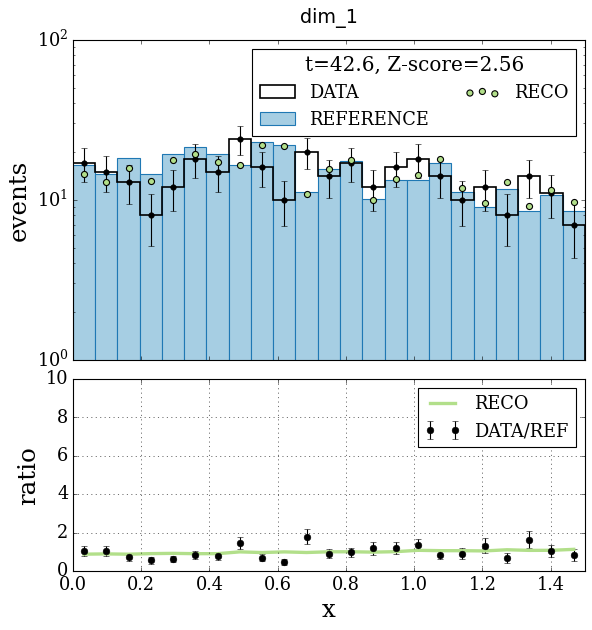

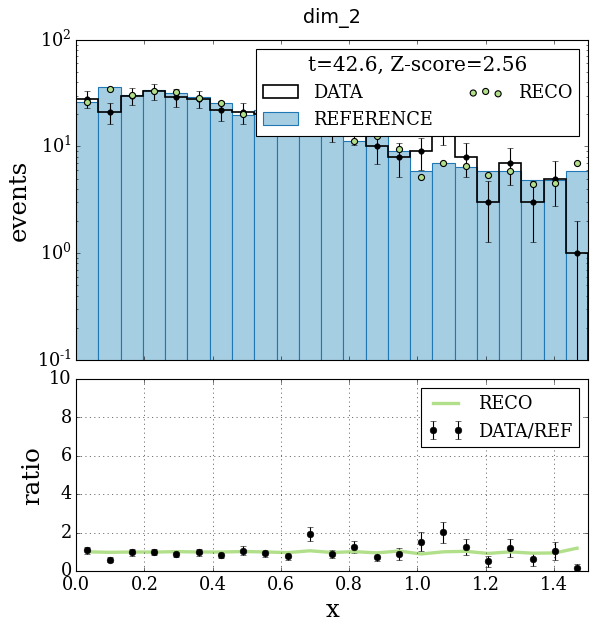

[--] Toy 1: 
[--] Reference shape:(1500, 2)
[--] Data shape:(801, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 53.80718613004274
Time = 0.78 sec
	
[--] Toy 2: 
[--] Reference shape:(1500, 2)
[--] Data shape:(779, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 38.21984118403161
Time = 0.45 sec
	
[--] Toy 3: 
[--] Reference shape:(1500, 2)
[--] Data shape:(753, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 45.59705777044819
Time = 0.66 sec
	
[--] Toy 4: 
[--] Reference shape:(1500, 2)
[--] Data shape:(859, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 57.57754901893034
Time = 0.4 sec
	
[--] Toy 5: 
[--] Reference shape:(1500, 2)
[--] Data shape:(827, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 78.05324897321042
Time = 0.52 sec
	
[--] Toy 6: 
[--] Reference shape:(1500, 2)
[--] Data shape:(803, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 53.99433781167852
Time = 0.43 sec
	
[--] Toy 7:

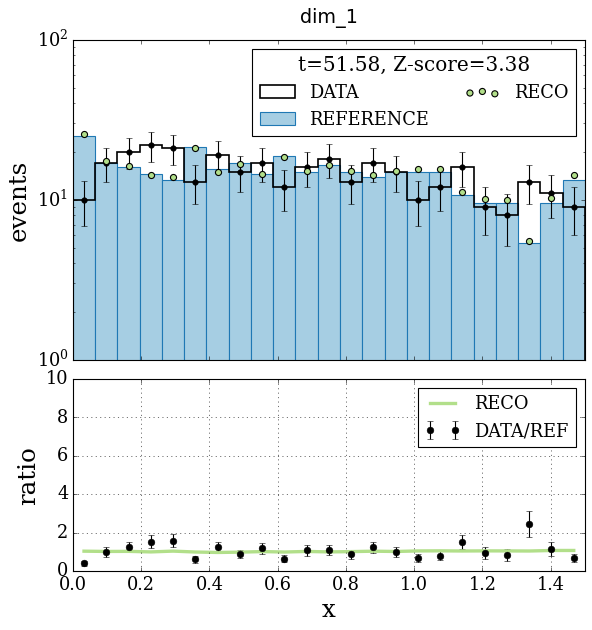

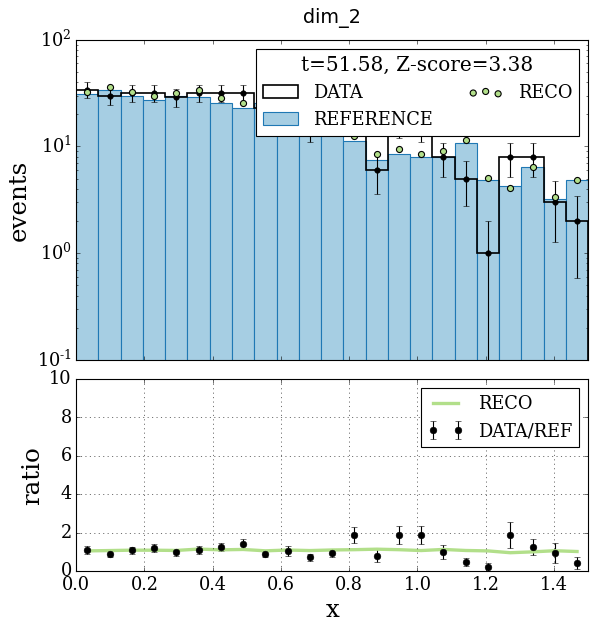

[--] Toy 101: 
[--] Reference shape:(1500, 2)
[--] Data shape:(859, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 63.50228518830575
Time = 0.64 sec
	
[--] Toy 102: 
[--] Reference shape:(1500, 2)
[--] Data shape:(768, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 54.95095504287847
Time = 0.46 sec
	
[--] Toy 103: 
[--] Reference shape:(1500, 2)
[--] Data shape:(784, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 62.63218184087191
Time = 0.44 sec
	
[--] Toy 104: 
[--] Reference shape:(1500, 2)
[--] Data shape:(832, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 42.6412758821941
Time = 0.46 sec
	
[--] Toy 105: 
[--] Reference shape:(1500, 2)
[--] Data shape:(756, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 62.75864838238508
Time = 0.35 sec
	
[--] Toy 106: 
[--] Reference shape:(1500, 2)
[--] Data shape:(762, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 71.01535096229046
Time = 0.41 sec
	

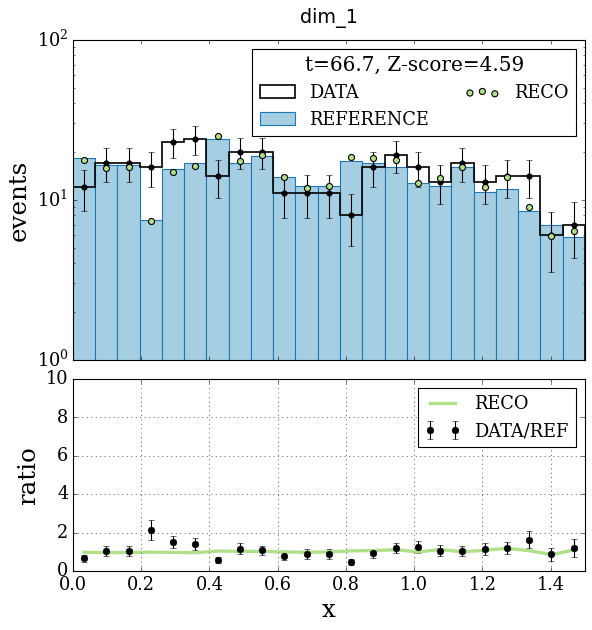

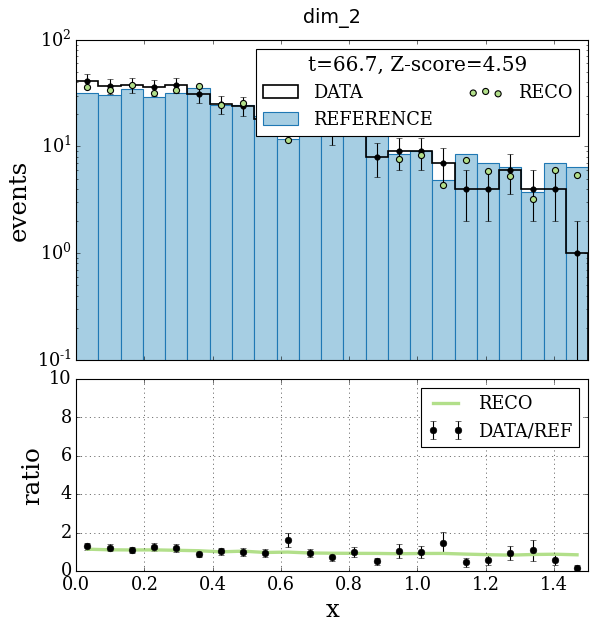

[--] Toy 201: 
[--] Reference shape:(1500, 2)
[--] Data shape:(799, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 57.14476159713533
Time = 0.47 sec
	
[--] Toy 202: 
[--] Reference shape:(1500, 2)
[--] Data shape:(787, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 56.14857860960408
Time = 0.55 sec
	
[--] Toy 203: 
[--] Reference shape:(1500, 2)
[--] Data shape:(825, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 51.1294129805806
Time = 0.52 sec
	
[--] Toy 204: 
[--] Reference shape:(1500, 2)
[--] Data shape:(803, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 37.78883832167157
Time = 0.48 sec
	
[--] Toy 205: 
[--] Reference shape:(1500, 2)
[--] Data shape:(845, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 74.07907351535944
Time = 0.58 sec
	
[--] Toy 206: 
[--] Reference shape:(1500, 2)
[--] Data shape:(835, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 61.59590319926664
Time = 0.55 sec
	

In [23]:
N_0 = 1500 # size of reference sample
N0 = 800 # expected background
weight = N0/N_0

M = 300
lam = 1e-8
flk_sigma = 3
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function

# null hypothesis
NS = 0 # expected NP component
run_toys("NP0", creds, fraud_samples, genuine_samples, "./reference/", N_0, N0, NS, flk_config, toys=np.arange(300), plots_freq= 100, df= 22)

In [24]:
best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])
best

(54.61349031790737, 0.04370377329794406)

[--] Toy 0: 
[--] Reference shape:(1500, 2)
[--] Data shape:(815, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 54.57419006931022
Time = 0.52 sec
	


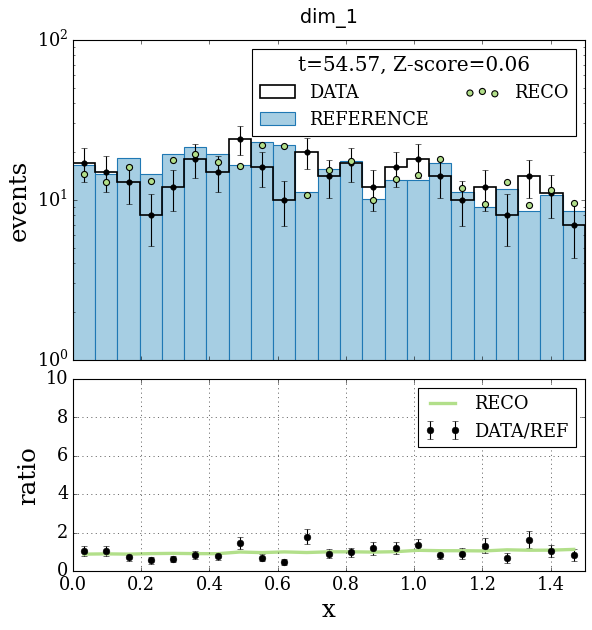

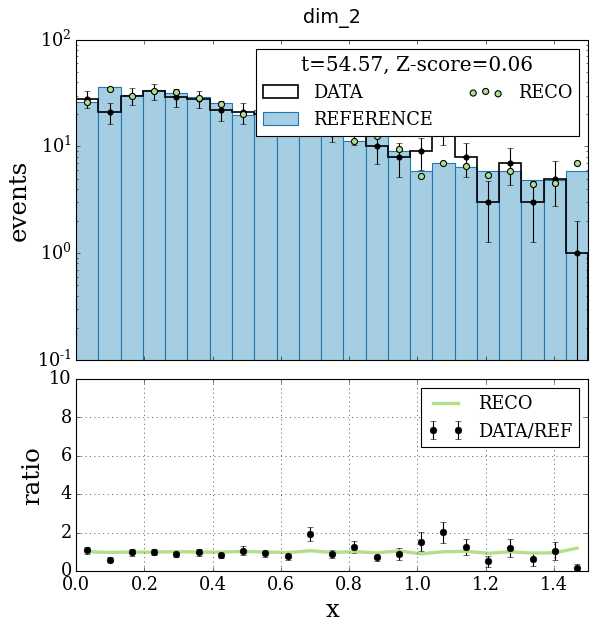

[--] Toy 1: 
[--] Reference shape:(1500, 2)
[--] Data shape:(812, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 58.970729755549925
Time = 0.96 sec
	
[--] Toy 2: 
[--] Reference shape:(1500, 2)
[--] Data shape:(796, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 75.3461799166034
Time = 0.75 sec
	
[--] Toy 3: 
[--] Reference shape:(1500, 2)
[--] Data shape:(770, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 66.89401117002123
Time = 0.72 sec
	
[--] Toy 4: 
[--] Reference shape:(1500, 2)
[--] Data shape:(884, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 115.50632175871905
Time = 0.92 sec
	
[--] Toy 5: 
[--] Reference shape:(1500, 2)
[--] Data shape:(840, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 96.59876025386427
Time = 0.64 sec
	
[--] Toy 6: 
[--] Reference shape:(1500, 2)
[--] Data shape:(814, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 78.43244317387571
Time = 0.83 sec
	
[--] Toy 

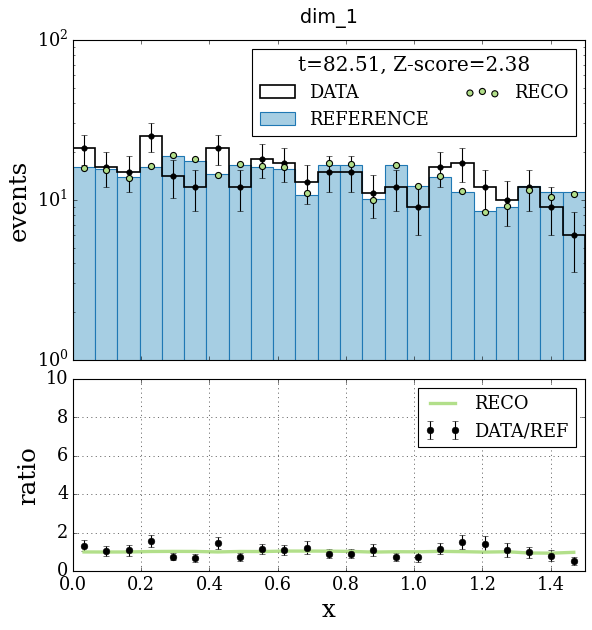

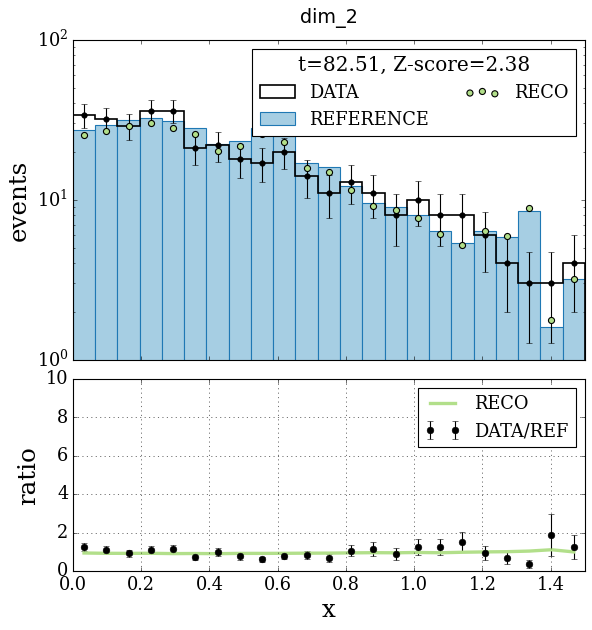

[--] Toy 26: 
[--] Reference shape:(1500, 2)
[--] Data shape:(816, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 100.52838098949053
Time = 0.83 sec
	
[--] Toy 27: 
[--] Reference shape:(1500, 2)
[--] Data shape:(825, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 52.050917688688756
Time = 0.58 sec
	
[--] Toy 28: 
[--] Reference shape:(1500, 2)
[--] Data shape:(850, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 73.11541777450431
Time = 0.75 sec
	
[--] Toy 29: 
[--] Reference shape:(1500, 2)
[--] Data shape:(749, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 84.47387439625346
Time = 0.67 sec
	
[--] Toy 30: 
[--] Reference shape:(1500, 2)
[--] Data shape:(784, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 71.98560878881419
Time = 0.76 sec
	
[--] Toy 31: 
[--] Reference shape:(1500, 2)
[--] Data shape:(859, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 137.05630225664538
Time = 1.03 sec
	
[

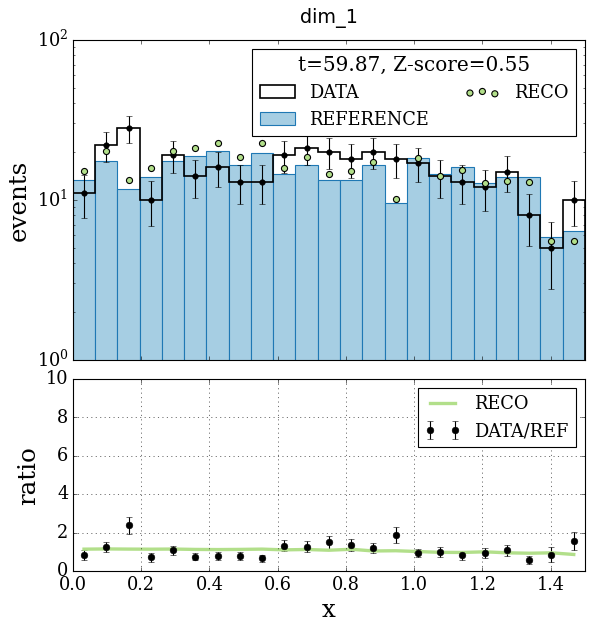

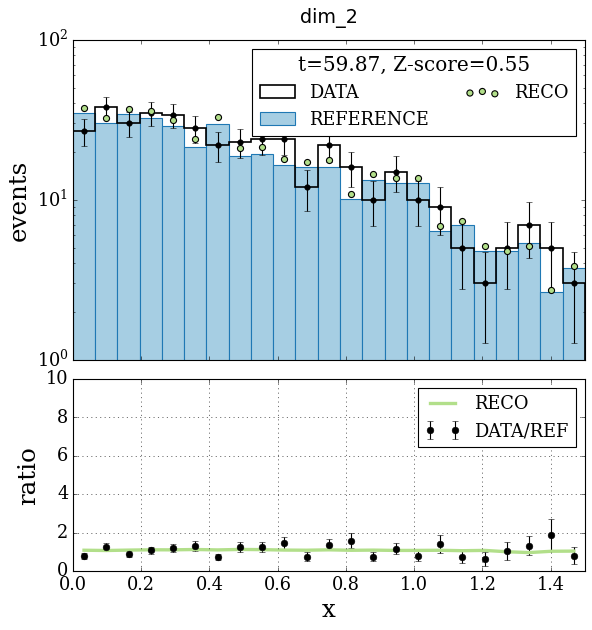

[--] Toy 51: 
[--] Reference shape:(1500, 2)
[--] Data shape:(869, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 99.88335091574484
Time = 1.05 sec
	
[--] Toy 52: 
[--] Reference shape:(1500, 2)
[--] Data shape:(822, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 87.49525489675531
Time = 0.95 sec
	
[--] Toy 53: 
[--] Reference shape:(1500, 2)
[--] Data shape:(794, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 70.63604951729337
Time = 1.1 sec
	
[--] Toy 54: 
[--] Reference shape:(1500, 2)
[--] Data shape:(782, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 60.66667399467531
Time = 0.66 sec
	
[--] Toy 55: 
[--] Reference shape:(1500, 2)
[--] Data shape:(841, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 104.61626786296925
Time = 0.85 sec
	
[--] Toy 56: 
[--] Reference shape:(1500, 2)
[--] Data shape:(832, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 84.49171705245851
Time = 0.83 sec
	
[--]

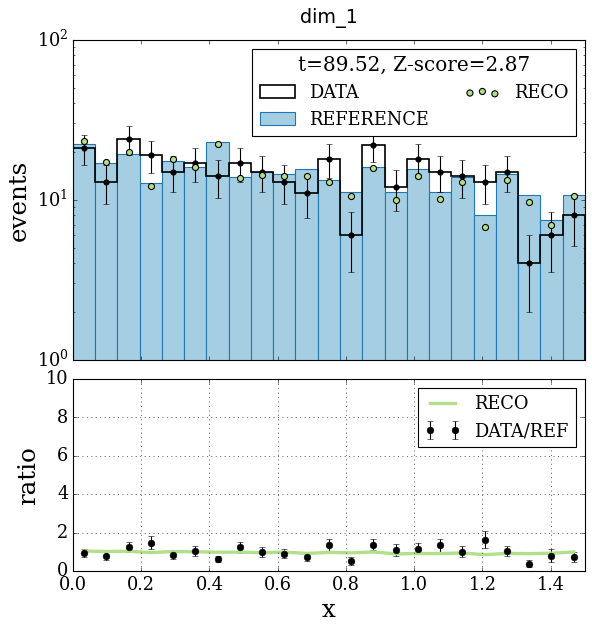

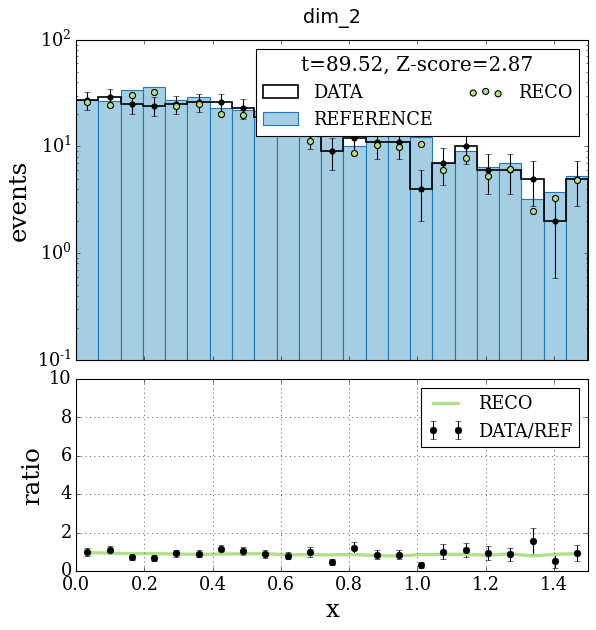

[--] Toy 76: 
[--] Reference shape:(1500, 2)
[--] Data shape:(822, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 94.62970753748661
Time = 0.62 sec
	
[--] Toy 77: 
[--] Reference shape:(1500, 2)
[--] Data shape:(835, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 84.76143107273279
Time = 0.71 sec
	
[--] Toy 78: 
[--] Reference shape:(1500, 2)
[--] Data shape:(806, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 90.77284198739835
Time = 0.62 sec
	
[--] Toy 79: 
[--] Reference shape:(1500, 2)
[--] Data shape:(868, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 105.06318948516446
Time = 0.61 sec
	
[--] Toy 80: 
[--] Reference shape:(1500, 2)
[--] Data shape:(834, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 86.72171455501869
Time = 0.84 sec
	
[--] Toy 81: 
[--] Reference shape:(1500, 2)
[--] Data shape:(814, 2)
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100
t = 107.27323433120229
Time = 0.83 sec
	
[-

In [25]:
N_0 = 1500 # size of reference sample
N0 = 800 # expected background
weight = N0/N_0

M = 300
lam = 1e-8
flk_sigma = 3
creds = pd.read_csv("drive/MyDrive/CreditCards/creditcard.csv")
fraud_samples = creds.loc[creds['Class'] == 1]
genuine_samples = creds.loc[creds['Class'] == 0]

flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=False) # seed is set inside learn_t function

# null hypothesis
NS = 13 # expected NP component
run_toys("NP1", creds, fraud_samples, genuine_samples, "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(100), plots_freq= 25, df= best[0])

In [26]:
np.mean(np.loadtxt('/content/runs/reference/time.txt',delimiter=',')[:,1])

OSError: ignored

In [ ]:
np.mean(np.loadtxt('/content/runs/NP1/time.txt',delimiter=',')[:,1])

FileNotFoundError: ignored

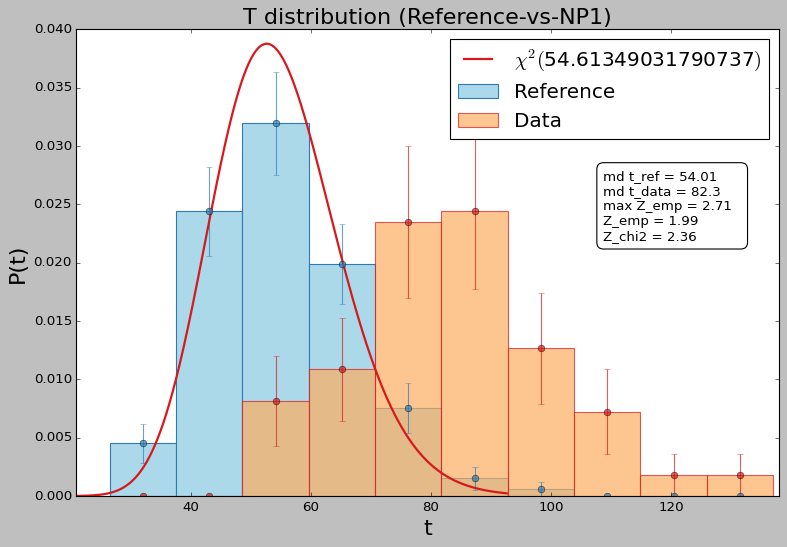

In [27]:
# in utils.py you additional functions can be found to plot the test statistics
tobs = np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1]
tobs = [t for t in tobs if t >= 0]  # remove the negative element

plot_ref_data(ref=np.array(tobs), data=np.loadtxt('/content/runs/NP1/t.txt',delimiter=',')[:,1], dof=best[0],
              name='NP1', out_path='./fig', title='T distribution (Reference-vs-NP1)', density=True, bins=10,
              c_ref='#abd9e9', e_ref='#2c7bb6', c_sig='#fdae61', e_sig='#d7191c')

In [ ]:
files.download("/content/fig/refdata_NP1.pdf")